# Final course project - Group 7

### The final course project (FCP) consists of a text classification task: you’re supposed to adjudicate between helpful and unhelpful movie reviews from the IMDB database.

In [4]:
# loading libraries
import warnings
warnings.filterwarnings('ignore')

# libraries for data manipulation
import numpy as np
import pandas as pd
import re

# libraries for visualization
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from plotly.subplots import make_subplots
from plotly import graph_objects as go

# tools for preprocessing input data
from nltk import word_tokenize
from nltk.tokenize import TreebankWordTokenizer
import spacy
nlp = spacy.load('en_core_web_lg')
import tomotopy as tp
import nltk
import tqdm
from nltk.corpus import stopwords

# download the stopwords from nltk
nltk.download('stopwords') 
stop = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import wordpunct_tokenize
import unicodedata
from collections import Counter, OrderedDict
#from wordcloud import WordCloud,STOPWORDS


# tools for creating ngrams and vectorizing input data
from gensim.models import Word2Vec, Phrases
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Phrases

# tools for building a model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import preprocessing
from sklearn.manifold import MDS
from sklearn.linear_model import LogisticRegression, RidgeClassifier, RidgeClassifierCV
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.naive_bayes import BernoulliNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

# loading library for dimensionality reduction
from sklearn.manifold import MDS

# tools for assessing the quality of model prediction
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve,  plot_precision_recall_curve
from sklearn.metrics import precision_score, recall_score, f1_score
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# tensoflow libraries
#!pip install tensorflow-text
import tensorflow_text as text
#!pip install tensorflow_hub
import tensorflow_hub as hub
#!pip install tensorflow-io

from __future__ import print_function
np.random.seed(1337)  # for reproducibility

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, TextVectorization, Bidirectional
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import MaxPooling1D
from keras.layers import Conv1D, Flatten
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau
from keras.layers.normalization.batch_normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import losses
from keras import optimizers
from keras.regularizers import l1, l2, L1L2

#!pip install keras-text-preprocessing
# pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

# tokenize
from tensorflow.keras.preprocessing.text import Tokenizer

#!pip install tf-models-official
from official.nlp import optimization
import h5py
import argparse
import os

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/georgekalfas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# loading the data

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submission_df = pd.read_csv('submission_file.csv')

### Having a look on the datasets.

In [69]:
# summary of the data
train_df.info()
print('-----------------------------------------------------')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10755 entries, 0 to 10754
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   helpfulness_cat   10755 non-null  float64
 1   imdb_user_review  10755 non-null  object 
 2   cleaned_review    10755 non-null  object 
dtypes: float64(1), object(2)
memory usage: 252.2+ KB
-----------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5071 entries, 0 to 5070
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   _id               5071 non-null   object
 1   imdb_user_review  5071 non-null   object
dtypes: object(2)
memory usage: 79.4+ KB


In [70]:
# counting the number of 'helpfulness_cat' that are 1 or 0
train_df['helpfulness_cat'].value_counts().to_frame()

,helpfulness_cat
1.0,8214
0.0,2541


## Preprocessing and visualizations of the data

### Based on some explonatary analysis & the visualizations:

#### 1. The `imdb_user_review` column was cleaned and converted to `cleaned_review` column
#### 2. Stopwords were removed

#### The process was applied on both the `train` & `test` datasets.

In [3]:
# passing the 'imdb_user_review' into a variable - train_df
imdb_user_review = [i.encode().decode('unicode-escape').replace("\\", "").replace("'","").replace('´','').replace('  ', '').replace('\n', '').replace('\t','').replace('&amp;', 'and') for i in train_df['imdb_user_review']]
imdb_user_review = [unicodedata.normalize('NFKD', i).encode('ascii','ignore').decode() for i in imdb_user_review]

In [ ]:
# passing the 'imdb_user_review' into a variable - test_df
imdb_user_review = [i.encode().decode('unicode-escape').replace("\\", "").replace("'","").replace('´','').replace('  ', '').replace('\n', '').replace('\t','').replace('&amp;', 'and') for i in test_df['imdb_user_review']]
imdb_user_review = [unicodedata.normalize('NFKD', i).encode('ascii','ignore').decode() for i in imdb_user_review]

### Visualizing the frequency of the Top Stopwords and the Top non Stopwords on the review text.

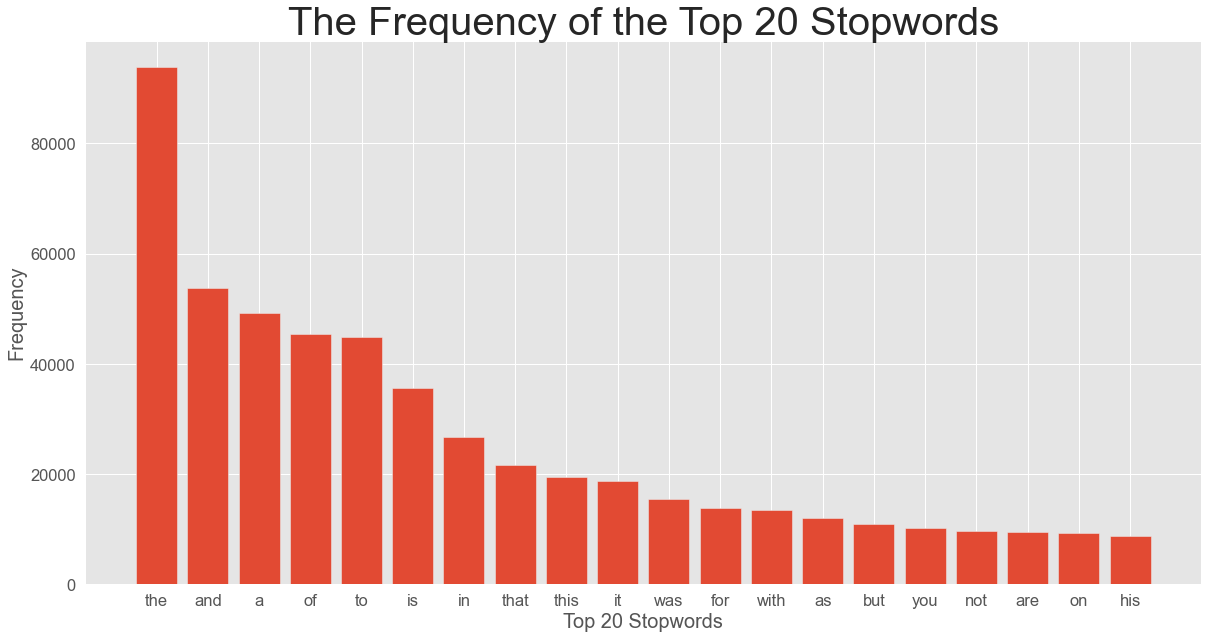

In [56]:
# plotting the top stopwords in the data
def plot_top_stopwords_barchart(text):
    
    new=text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(),key=lambda x:x[1],reverse=True)[:20]
    x,y=zip(*top)
    plt.figure(figsize=(20,10))
    plt.xlabel('Top 20 Stopwords').set_fontsize(20)
    plt.ylabel('Frequency').set_fontsize(20)
    plt.bar(x,y)
    plt.title("The Frequency of the Top 20 Stopwords").set_fontsize(40)
    
plot_top_stopwords_barchart(train_df['imdb_user_review'])

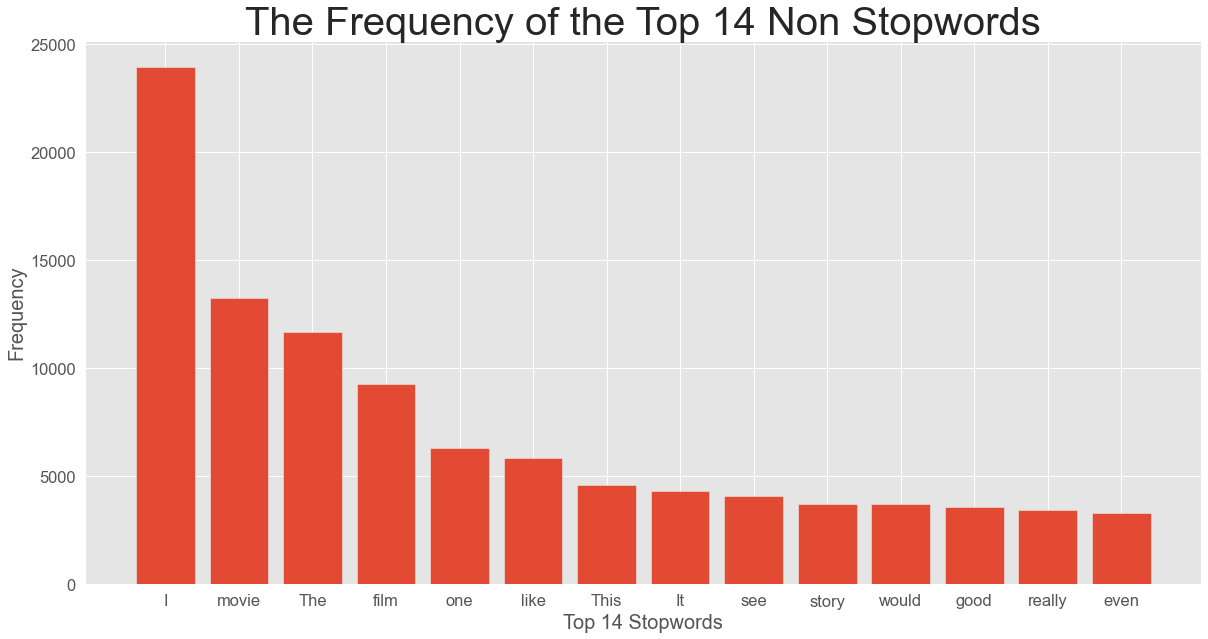

In [57]:
# plotting the top non stopwords in the data
def plot_top_non_stopwords_barchart(text):

  new=text.str.split()
  new=new.values.tolist()
  corpus=[word for i in new for word in i]

  counter=Counter(corpus)
  most=counter.most_common()
  x,y=[],[]
  for word,count in most[:70]:
    if (word not in stop):
      x.append(word)
      y.append(count)

  plt.figure(figsize=(20,10))
  plt.xlabel('Top 14 Stopwords').set_fontsize(20)
  plt.ylabel('Frequency').set_fontsize(20)
  plt.bar(x,y)
  plt.title("The Frequency of the Top 14 Non Stopwords").set_fontsize(40)

plot_top_non_stopwords_barchart(train_df['imdb_user_review'])

### **Cleaning the stopwords from the review**

In [5]:
# removing the stop words from the imdb_user_review - `train_df`

def clean(review):
    clean_non_letters = re.sub("[^a-zA-Z]", " ", review)
    cleaned_lowercase = clean_non_letters.lower()
    words = cleaned_lowercase.split()
    cleaned_words = [w for w in words if w not in stop]
    return " ".join(cleaned_words)

train_df["cleaned_review"] = train_df['imdb_user_review'].apply(clean)
train_df.head()

In [ ]:
# removing the stop words from the imdb_user_review - `test_df`

def clean(review):
    clean_non_letters = re.sub("[^a-zA-Z]", " ", review)
    cleaned_lowercase = clean_non_letters.lower()
    words = cleaned_lowercase.split()
    cleaned_words = [w for w in words if w not in stop]
    return " ".join(cleaned_words)

test_df["cleaned_review"] = test_df['imdb_user_review'].apply(clean)
test_df.head()

In [64]:
# Finding the most Frequent Words in the reviews with helpfulness_cat == 0  

cnt = Counter()

for text in (train_df[train_df['helpfulness_cat']==0.0]['cleaned_review']).values:
    for word in text.split():
        cnt[word] += 1
cnt.most_common(10)
temp = pd.DataFrame(cnt.most_common(10))
temp.columns=['word', 'count']
temp

,word,count
0,movie,4537
1,film,2301
2,like,1452
3,one,1403
4,good,1074
5,people,967
6,see,945
7,story,909
8,would,902
9,time,885


In [65]:
# Finding the most Frequent Words in the reviews with helpfulness_cat == 1  

for text in (train_df[train_df['helpfulness_cat']==1.0]['cleaned_review']).values:
    for word in text.split():
        cnt[word] += 1
cnt.most_common(10)
temp_1 = pd.DataFrame(cnt.most_common(10))
temp_1.columns=['word', 'count']
temp_1

,word,count
0,movie,18955
1,film,13623
2,one,8095
3,like,6431
4,story,5304
5,good,4737
6,see,4591
7,time,4411
8,people,3900
9,would,3887


### Visualizations of the most frequent words in the reviews for both categories (`helpful` & `not helpful`).

In [66]:
# Visualizing the most frequent words in the reviews with helpfulness_cat == 0 and helpfulness_cat == 1

fig = make_subplots(rows=1, cols=2)

# Subplot 1
fig.add_trace(
    go.Bar(
        name = "helpfulness_cat == 0",
        x=temp['count'],
        y=temp["word"],
        orientation='h'),
    row=1,
    col=1,
)

#  Subplot 2
fig.add_trace(
    go.Bar(
        name="helpfulness_cat == 1",
        x=temp_1["count"],
        y=temp_1["word"],
        orientation='h'),
    row=1,
    col=2,
)


In [67]:
# Creating a function for ploting the wordcloud

def plot_wordcloud(text):
  def _preprocess_text(text):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for news in text:
      words=[w for w in word_tokenize(news) if (w not in stop)]
      words=[lem.lemmatize(w) for w in words if len(w)>2]
      corpus.append(words)
    return corpus

  corpus=_preprocess_text(text)
  
  wordcloud=WordCloud(
      background_color='white',
      stopwords=set(STOPWORDS),
      max_words=100,
      max_font_size=30,
      scale=3,
      random_state=1
  )
  wordcloud=wordcloud.generate(str(corpus))
  return wordcloud

In [ ]:
# Visualizing the most frequent words in the train set by review category

fig = plt.figure(figsize=(20,20)) 
rows = 2
cols = 1

for i in range(2):
    cloud=WordCloud(width=800, height=600).generate(" ".join(train_df[train_df['helpfulness_cat']==i]['cleaned_review'])) # join function can help merge all words into one string. " " means space can be a sep between words.
    plt.figure(figsize=(15,10))
    plt.imshow(cloud)
    plt.title(i)
    plt.axis('off')

## Moving forward, and after cleaning the datasets we implemented 4 different NLP tools:

#### 1. `Bag of Words (BoW)` 
#### 2. `TF-IDF`
#### 3. `Doc2Vec`
#### 4. `Topic-to-document probabilities (Topic-modeling)`

# **BoW Implementation**

#### A Bag of Words (BoW) model is a simple algorithm used in Natural Language Processing. It simply counts the number of times a word appears in a document.
#### The BoW model is used in computer vision, natural language processing (NLP), Bayesian spam filters, document classification and information retrieval by artificial intelligence (AI). In a BoW a body of text, such as a sentence or a document, is thought of as a bag of words (Jason Brownlee, 2017). 
##### Source: `https://machinelearningmastery.com/gentle-introduction-bag-words-model/`

#### The BoW model is a way of representing text data when modeling text with machine learning algorithms. The bag-of-words model is simple to understand and implement and has seen great success in problems such as language modeling and document classification (Praveen Dubey, 2018).
##### Source: `https://medium.com/free-code-camp/an-introduction-to-bag-of-words-and-how-to-code-it-in-python-for-nlp-282e87a9da04`

#### In many applications where we use our words as input in Machine Learning Models or in Deep Learning etc. we can't directly use our words as text and character input as machines can't perform numerical and analytical tasks directly on character sequences and perform better when given numerical tasks (Victor Zhou, 2019).

#### To rectify this we convert words into vectors and then use the techniques of Linear Algebra and Optimization which are readily available to us to work on our data. We can convert words into vectors using many different methods and there are already many different data sources available online that provide us with pre-computed vectors for words (Victor Zhou, 2019).
##### Source: `https://towardsdatascience.com/a-simple-explanation-of-the-bag-of-words-model-b88fc4f4971`

In [ ]:
# define a vocabulary
# get a list of tokenized docs
docs_tkns = []
for doc in imdb_user_review:
    tmp = [
        token.lemma_  # --- reduces the noise in the text
        for token in nlp(doc) 
        if (not token.is_punct) & (not token.is_stop) & (token.is_alpha)
    ]
    docs_tkns.append(tmp)
    del tmp

# vocabulary (dictionary or lexicon)
vocab = sorted(set(sum(docs_tkns, [])))

# iterate over tokenized imdb_user_review and project them onto the vocabulary
vector_space = []
for doc in docs_tkns:
    vector = OrderedDict((token, 0) for token in vocab)
    tkns_count = Counter(doc)
    for k, v in tkns_count.items():
        vector[k] = v 
    vector_space.append(vector)
    del vector

In [ ]:
# converting vector space to a dataframe
vector_space_df = pd.DataFrame(vector_space) 

In [ ]:
# applying MDS to reduce the dimensionality of the data

transformer = MDS(n_components = 2)
transformed = transformer.fit_transform(vector_space_df)
transformed = pd.DataFrame(transformed, columns = ['x', 'y'])
transformed.head()

,x,y
0,9.599201,1.303573
1,17.370481,-13.459288
2,-5.685441,-4.642546
3,-6.939367,20.089469
4,3.119391,3.314441


### Visualising the transformed Dataframe

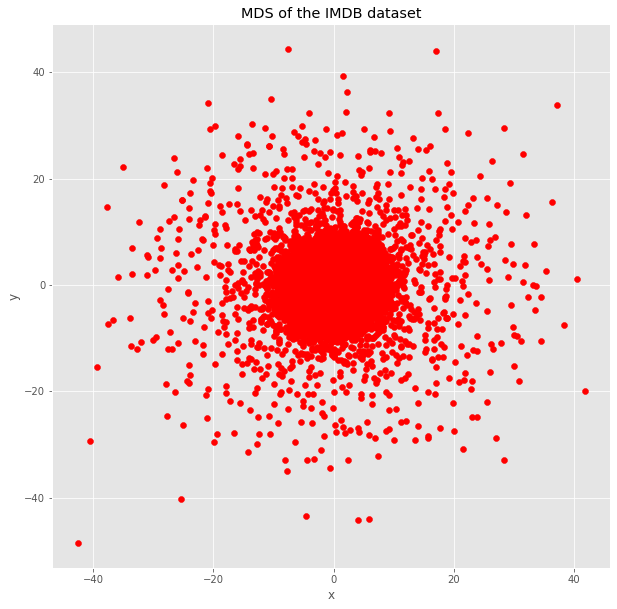

In [ ]:
# create the figure
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111)

# title and labels
ax.set_title('MDS of the IMDB dataset')
ax.set_xlabel('x')
ax.set_ylabel('y')

# populate the figure
ax.scatter(transformed['x'], transformed['y'], c = 'red')

# show the figure
plt.show()

## TF-IDF and N-Grams

#### TF-IDF (or Term Frequency-Inverse Document Frequency) on the other hand reflects how important a word is to a document, or corpus. With TF-IDF, words are given weight, measured by relevance, rather than frequency.

#### It is the product of two statistics:

#### Term Frequency (TF): The number of times a word appears in a given document.
#### Inverse Document Frequency (IDF): The more documents a word appears in, the less valuable that word is as a signal. Very common words, such as “a” or “the”, thereby receive heavily discounted tf-idf scores, in contrast to words that are very specific to the document in question (Nikhil Karve, 2022).
#### Source: `https://medium.com/@nikhilkarve007/implementing-tfidf-from-scratch-f2be7f9b6557`

In [ ]:
# ---+ define a vocabulary
# --+ get a list of tokenized docs
docs_tkns = []
for doc in imdb_user_review:
    tmp = [
        token.lemma_
        for token in nlp(doc)
        if (not token.is_stop) & (not token.is_punct) & (token.is_alpha)
    ]
    docs_tkns.append(tmp)
    del tmp
# --+ build the vocabulary and display it
voc = sorted(set(sum(docs_tkns, [])))
print(voc)
# let's project the individual docs onto the vocabulary
# --+ an empty container for the TFIDF transformations
vector_space = []
# --+ let's store the vectors associated to the individual docs
for doc in docs_tkns:
    vector = OrderedDict((token, 0) for token in voc)
    tkns_count = Counter(doc)
    for k, v in tkns_count.items():
        tf = np.log10(v + 1)
        docs_with_key = 0
        for doc_ in docs_tkns:
            if k in doc_:
                docs_with_key += 1
        if docs_with_key:
            idf = np.log10(len(docs_tkns) / docs_with_key)
        else:
            idf = 0
        vector[k] = np.round(tf * idf, 4)
    vector_space.append(vector)

In [ ]:
word_vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', sublinear_tf=True, strip_accents='unicode', 
                                  stop_words='english', ngram_range=(1, 1), max_features=10000)
word_vectorizer.fit(imdb_user_review)

train_word_features = word_vectorizer.transform(imdb_user_review)

In [ ]:
char_vectorizer = TfidfVectorizer(analyzer='char', sublinear_tf=True, strip_accents='unicode', 
                                  stop_words='english', ngram_range=(1, 3), max_features=50000)
char_vectorizer.fit(imdb_user_review)

train_char_features = char_vectorizer.transform(imdb_user_review)

In [ ]:
print(train_word_features)

  (0, 9966)	0.08807689362909585
  (0, 9903)	0.08191362207593952
  (0, 9718)	0.056915986871182635
  (0, 9435)	0.10909432375646047
  (0, 9351)	0.1637353769572475
  (0, 9308)	0.16706273208565356
  (0, 9102)	0.09094594953666446
  (0, 8986)	0.11497937117740123
  (0, 8860)	0.1400217401641689
  (0, 8613)	0.13232288210387105
  (0, 8574)	0.11700445674085093
  (0, 8548)	0.04654250409652017
  (0, 8471)	0.09539533018051018
  (0, 8219)	0.09329081994777233
  (0, 8058)	0.0860448957517513
  (0, 8019)	0.28286179380746584
  (0, 7945)	0.10528189018238637
  (0, 7943)	0.08546260388300901
  (0, 7876)	0.08082735099268362
  (0, 7865)	0.1458914518243118
  (0, 7788)	0.06556979608068095
  (0, 7786)	0.11668989595050222
  (0, 6819)	0.11225877182922353
  (0, 6622)	0.08143163848760206
  (0, 6591)	0.09169961999660785
  :	:
  (5068, 4999)	0.19806656802445943
  (5068, 4993)	0.29064380584959626
  (5068, 4376)	0.15484525330208138
  (5068, 3986)	0.3049842014387762
  (5068, 3775)	0.25715604194662345
  (5068, 3701)	0.148510

In [ ]:
print(train_char_features)

  (0, 20787)	0.02836997159387616
  (0, 20768)	0.026554965755254973
  (0, 20679)	0.03625446211234024
  (0, 20657)	0.02044430435492351
  (0, 20544)	0.08204616531071345
  (0, 20511)	0.02265355739481884
  (0, 20510)	0.03418163620000536
  (0, 20463)	0.021274751030425264
  (0, 20462)	0.021183611097588824
  (0, 20407)	0.04298591383165595
  (0, 20405)	0.020652638234524373
  (0, 20402)	0.017351137118894962
  (0, 20401)	0.04299365507297645
  (0, 20393)	0.03963027806465079
  (0, 20390)	0.024223778687941157
  (0, 20389)	0.026899754412833623
  (0, 20387)	0.026239945597033774
  (0, 20386)	0.02329133221266455
  (0, 20383)	0.017418518545378396
  (0, 20357)	0.03880190889186037
  (0, 20356)	0.042069980629496
  (0, 20315)	0.05092660210937862
  (0, 20303)	0.031193085789068316
  (0, 20295)	0.049279111878288456
  (0, 20289)	0.024208678047012225
  :	:
  (5070, 7376)	0.08123939669297356
  (5070, 7358)	0.03859929080535661
  (5070, 7097)	0.15615832491367523
  (5070, 7075)	0.046263313742957494
  (5070, 6925)	0.2

# **Doc2Vec for comparisons**

## Word2Vec

#### Word2vec is a well known concept, used to generate representation vectors out of words.

#### Describing `doc2vec` without `word2vec` will miss the point, so let's see what `word2vec` is all about.

#### In general, when you like to build some model using words, simply labeling/one-hot encoding them is a plausible way to go. However, when using such encoding, the words lose their meaning. e.g, if we encode Paris as id_4, France as id_6 and power as id_8, France will have the same relation to power as with Paris. We would prefer a representation in which France and Paris will be closer than France and power.

#### The word2vec, intends to give just that: a numeric representation for each word, that will be able to capture such relations as above. this is part of a wider concept in machine learning — the feature vectors (Gidi Shperber, 2017).

## Doc2Vec

#### The goal of doc2vec is to create a numeric representation of a document, regardless of its length. But unlike words, documents do not come in logical structures such as words, so the another method has to be found (Gidi Shperber, 2017).

#### Source: `https://medium.com/wisio/a-gentle-introduction-to-doc2vec-db3e8c0cce5e`

In [77]:
# tokenize the words
tkn_reviews = [wordpunct_tokenize(review.lower()) for review in imdb_user_review]
tgd_reviews = [TaggedDocument(tkn, [i]) for i, tkn in enumerate(tkn_reviews)] 

In [ ]:
# train the doc2vec model
model = Doc2Vec(tgd_reviews, vector_size = 300, window = 2, min_count = 1, workers = 4, epochs = 5)

# vector_size --> dimensionality of the vectors
# window --> the number of words to the left and right of the target word
# min_count --> the minimum number of times a word must appear in the training data to be included in the model
# workers --> the number of worker threads to use when training the model
# epochs --> the number of iterations to train the model

In [ ]:
# creating a list for the doc2vec vectors
doc2vec_vectors = np.array([model.dv[i] for i in range(len(model.dv))]).reshape(len(imdb_user_review), 300)

In [ ]:
# reducing the dimensionality of the data --> applying MDS
transformer = MDS(n_components = 2)
transformed = transformer.fit_transform(doc2vec_vectors)
transformed = pd.DataFrame(transformed, columns = ['x', 'y'])
transformed.head()

,x,y
0,0.598079,-0.429047
1,0.566558,1.192479
2,0.361428,-0.944624
3,0.489220,0.229809
4,0.651549,-0.456743


In [ ]:
# saving into a csv file the numpy.ndarray of the transformed data
np.savetxt('doc2_vec.csv', doc2vec_vectors, delimiter = ',')

In [ ]:
# dropping imdb_user_review from the train_df
cat_df = train_df.drop(['imdb_user_review'], axis = 1)

In [ ]:
# concatinating the transfromed dataframe with the cat_df
concatinated_df = pd.concat([cat_df, transformed], axis = 1)

### Visualising the Doc2Vec data

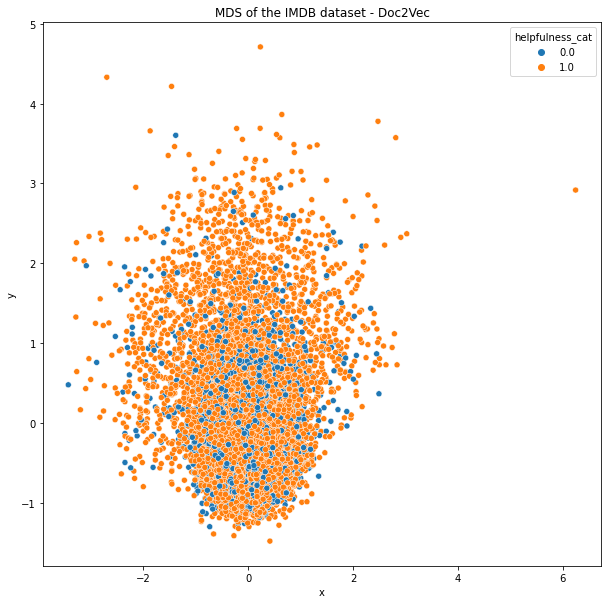

In [ ]:
# create the figure
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111)

# title and labels
ax.set_title('MDS of the IMDB dataset - Doc2Vec')
ax.set_xlabel('x')
ax.set_ylabel('y')

# populate the figure
sns.scatterplot(x = 'x', y = 'y', data = concatinated_df, hue = 'helpfulness_cat', ax = ax)

# show the figure
plt.show()

# **Topic to Document**

#### Topic modeling is a type of statistical modeling tool which is used to assess what all abstract topics are being discussed in a set of documents. Topic modeling, by its construction solves the problem of creating topic in an unsupervised manner.

#### The topic modeling is generally performed by counting words, their proportions and related indicators. I will describe two models, LSA ( latent semantic analysis) and LDA ( latent dirichlet analysis) based on the idea I just discussed.

#### Topic modeling is therefore an unsupervised machine learning method, which is used to model topics out of an unlabelled data and it can work therefore without any training. For obvious reasons, topic modeling is therefore a rough beginning approach rather than being a sophisticated and end solution (Ankur Dhuriya, 2021).
#### Source: `https://medium.com/analytics-vidhya/what-is-topic-modeling-161a76143cae`

In [ ]:
# splitting the data into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(train_df['cleaned_review'], train_df['helpfulness_cat'], train_size=0.9, random_state=7, stratify=train_df['helpfulness_cat'])

In [ ]:
# Todo:
# define custom stopwords, implement bigrams and trigrams
# inspect first topic model and identify popular stop words to then be removed, sorting probabilities by descending order
# potential custom stopwords: film, scene, character

## Next steps:

#### 1. Increasing the interpretability of the topics. 
#### 2. Identifying the bi-grams & tri-grams included in the corpus.
#### 3. Use of Gensim's phrases `method`, included in the module `models`.

In [ ]:
# creating a function with relevant preprocessing of comments to choose k topic models using LDA, and finalising
# the one k with the best coherence score
def tm(comments,k):
    stopwords = ['\n', '  ', '`', ' ', '´', 'film', 'movie', 'character', 's'] #possible ones: movie, film, chracter, book, amp
    for item in stopwords:                      
         nlp.vocab[item].is_stop = True
    docs_tokens, tmp_tokens = [], []
    for comment in comments:
        tmp_tokens = [
            token.lemma_
            for token in nlp(comment)
            if not token.is_stop and not token.is_punct and not token.like_num
        ]
        docs_tokens.append(tmp_tokens)
        tmp_tokens = []

    bigram = Phrases(                              # step 1 
        docs_tokens,
        min_count=50,
        threshold=5,
        max_vocab_size=50000,
        
    )
    trigram = Phrases(                             # step 2
        bigram[docs_tokens],
        min_count=50,
        threshold=5,
        max_vocab_size=50000,
        
    )

    docs_phrased = [trigram[bigram[line]] for line in docs_tokens]
    corpus = tp.utils.Corpus()
    # populate the corpus
    for item in docs_phrased:
        corpus.add_doc(words=item)
    cvs = {}                                    # step 1
    for topic_number in range(1, k+1, 1):        # step 2
        mdl = tp.LDAModel(k=topic_number, corpus=corpus)
        for i in range(0, 100, 10):
            mdl.train(10)
            print("Iteration: {}\tLog-likelihood: {}".format(i, mdl.ll_per_word))
        coh = tp.coherence.Coherence(mdl, coherence="u_mass")
        cvs[topic_number] = coh.get_score()

    fig = plt.figure(figsize=(25, 8))
    ax = fig.add_subplot(111)
    ax.plot(cvs.keys(), cvs.values(), "o-")
    ax.set_xlabel("Number of topics retained")
    ax.set_ylabel("Coherence score")
    ax.set_xticks(range(1,k+1,1))
    plt.show()
    topic_size=min(cvs, key=cvs.get)
    best_mdl = tp.LDAModel(k=topic_size, corpus=corpus)
    
    return (cvs, corpus, best_mdl, topic_size, docs_phrased)


Iteration: 0	Log-likelihood: -8.617198062069171
Iteration: 10	Log-likelihood: -8.617198062069171
Iteration: 20	Log-likelihood: -8.617198062069171
Iteration: 30	Log-likelihood: -8.617198062069171
Iteration: 40	Log-likelihood: -8.617198062069171
Iteration: 50	Log-likelihood: -8.617198062069171
Iteration: 60	Log-likelihood: -8.617198062069171
Iteration: 70	Log-likelihood: -8.617198062069171
Iteration: 80	Log-likelihood: -8.617198062069171
Iteration: 90	Log-likelihood: -8.617198062069171
Iteration: 0	Log-likelihood: -9.076766280592222
Iteration: 10	Log-likelihood: -8.975620110345874
Iteration: 20	Log-likelihood: -8.86613766769489
Iteration: 30	Log-likelihood: -8.82105869251929
Iteration: 40	Log-likelihood: -8.800465482499762
Iteration: 50	Log-likelihood: -8.788183242524928
Iteration: 60	Log-likelihood: -8.780607831033496
Iteration: 70	Log-likelihood: -8.777038115111083
Iteration: 80	Log-likelihood: -8.77368233491129
Iteration: 90	Log-likelihood: -8.770442842453805
Iteration: 0	Log-likeliho

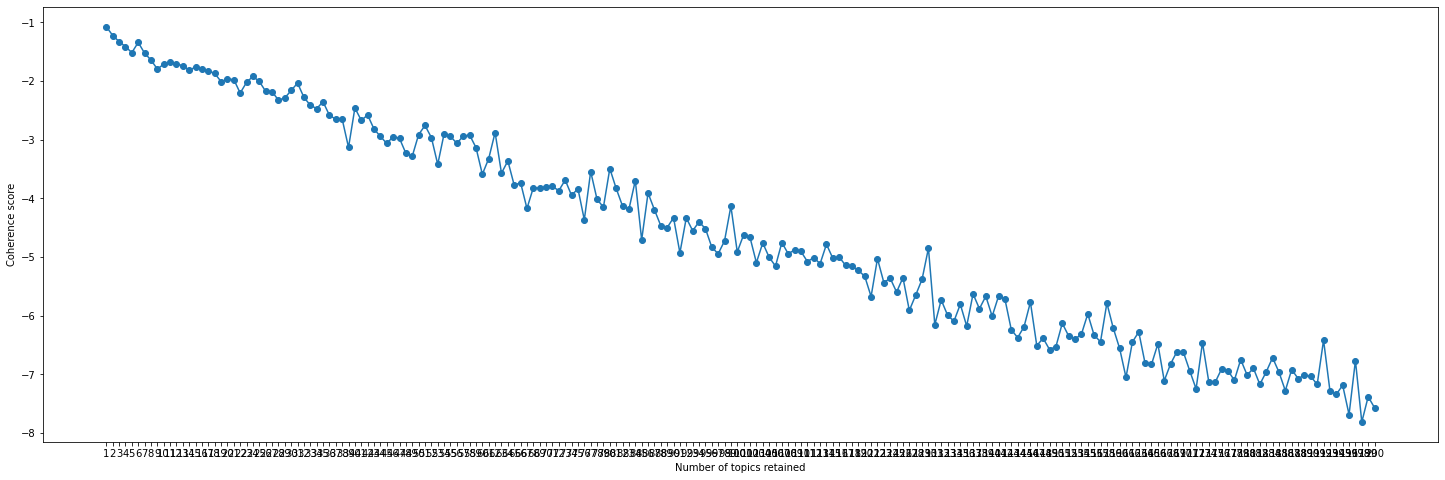

In [ ]:
## Training 200 LDAs to choose the best topic size
cvs, corpus, best_mdl, topic_size, docs_phrased = tm(comments=X_train.to_numpy(),k=200)

In [ ]:
def train_tm(model):
    for i in range(0, 100, 4):
        model.train(10)
        print("Iteration: {}\tLog-likelihood: {}".format(i, model.ll_per_word))
    return(model)

In [ ]:
best_mdl_trained = train_tm(best_mdl)

Iteration: 0	Log-likelihood: -10.87612312091086
Iteration: 4	Log-likelihood: -10.451918686721998
Iteration: 8	Log-likelihood: -10.245587666156348
Iteration: 12	Log-likelihood: -10.095963879835356
Iteration: 16	Log-likelihood: -9.976403351524235
Iteration: 20	Log-likelihood: -9.87190960706999
Iteration: 24	Log-likelihood: -9.780178834172625
Iteration: 28	Log-likelihood: -9.704848237340611
Iteration: 32	Log-likelihood: -9.635479476564962
Iteration: 36	Log-likelihood: -9.583252010548266
Iteration: 40	Log-likelihood: -9.535349671329783
Iteration: 44	Log-likelihood: -9.498927141839312
Iteration: 48	Log-likelihood: -9.467126710319448
Iteration: 52	Log-likelihood: -9.43870453119359
Iteration: 56	Log-likelihood: -9.416146262708725
Iteration: 60	Log-likelihood: -9.396764321872556
Iteration: 64	Log-likelihood: -9.379642171904798
Iteration: 68	Log-likelihood: -9.36473361828562
Iteration: 72	Log-likelihood: -9.348681564450978
Iteration: 76	Log-likelihood: -9.336377918866685
Iteration: 80	Log-likel

In [ ]:
# Topic to word probabilities to understand words with the highest probabilities to occur in a topic and then
# to perhaps go back and include those words in custom stopwords in the LDA code
wt = pd.DataFrame()
for k in range(best_mdl_trained.k):
    words, probs = [], []
    for word, prob in best_mdl.get_topic_words(k):
        words.append(word)
        probs.append(prob)
    tmp = pd.DataFrame(
        {
            "word": words,
            "prob": np.round(probs, 3),
            "k": np.repeat(k, len(words)),
            "sort": np.arange(0, len(words)),
        }
    )
    wt = pd.concat([wt, tmp], ignore_index=False)
    del tmp

In [ ]:
wt.sort_values('prob', ascending=False).head(40)

,word,prob,k,sort
0,book,0.205,13,0
0,original,0.169,100,0
0,kid,0.158,167,0
0,woman,0.154,86,0
0,action,0.146,98,0
0,monster,0.139,10,0
0,Tom,0.130,9,0
0,love,0.129,119,0
0,see,0.126,28,0
0,alien,0.118,57,0


In [ ]:
#Dataframe withe final k=198 topics
train_td = pd.DataFrame(
    np.stack([doc.get_topic_dist() for doc in best_mdl.docs]),
    columns=["Topic {}".format(i + 1) for i in range(best_mdl.k)])
train_td

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,Topic 189,Topic 190,Topic 191,Topic 192,Topic 193,Topic 194,Topic 195,Topic 196,Topic 197,Topic 198
0,0.000990,0.000249,0.000243,0.000509,0.001619,0.000220,0.000244,0.000287,0.000290,0.000362,...,0.004389,0.000263,0.000258,0.000293,0.004994,0.003268,0.002081,0.000269,0.004735,0.000189
1,0.000604,0.000152,0.000148,0.000310,0.000987,0.000134,0.000149,0.000175,0.000177,0.000221,...,0.002675,0.000160,0.000157,0.000179,0.003044,0.001992,0.001268,0.000164,0.002886,0.000115
2,0.000614,0.000155,0.000150,0.000315,0.001004,0.000136,0.000151,0.000178,0.000180,0.000224,...,0.002721,0.000163,0.000160,0.000182,0.037636,0.002026,0.001290,0.000167,0.002936,0.000117
3,0.036411,0.000160,0.000156,0.000327,0.001040,0.000141,0.000157,0.000184,0.000186,0.000232,...,0.020706,0.000169,0.000166,0.000188,0.021095,0.002099,0.001336,0.000173,0.003041,0.000121
4,0.000462,0.000116,0.000113,0.000237,0.000756,0.000103,0.000114,0.000134,0.000136,0.000169,...,0.015052,0.000123,0.000121,0.000137,0.002332,0.001526,0.039981,0.000126,0.002211,0.000088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9674,0.001019,0.000256,0.000250,0.000523,0.001665,0.000226,0.000251,0.000295,0.000299,0.000372,...,0.004514,0.000270,0.000266,0.000302,0.005137,0.003361,0.002141,0.000277,0.004871,0.000195
9675,0.000468,0.000118,0.000115,0.000241,0.000766,0.000104,0.000116,0.000136,0.000137,0.000171,...,0.002076,0.000124,0.000122,0.000139,0.002362,0.001546,0.000984,0.000127,0.002240,0.000089
9676,0.067226,0.000119,0.000116,0.000244,0.000776,0.000105,0.000117,0.000137,0.000139,0.000173,...,0.002104,0.000126,0.000124,0.000141,0.002394,0.001566,0.000997,0.000129,0.002270,0.000091
9677,0.000914,0.000230,0.000224,0.000469,0.001494,0.000203,0.000225,0.000265,0.000268,0.000334,...,0.004050,0.000242,0.000238,0.000271,0.004609,0.003016,0.001920,0.000248,0.004370,0.000175


In [ ]:
# inspecting topic themes as a dataframe just out of curiosity.
values = {}
for k in range(best_mdl.k):
    values['Topic {}'.format(k)]= [("{},({})".format(word, str(np.round(prob, 3)))) for word, prob in best_mdl.get_topic_words(k)]
    # print the table
    #return (table)
table = pd.DataFrame(values)   

In [ ]:
table

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,...,Topic 188,Topic 189,Topic 190,Topic 191,Topic 192,Topic 193,Topic 194,Topic 195,Topic 196,Topic 197
0,"kill,(0.109)","Brad,(0.041)","french,(0.035)","camp,(0.037)","Oscar,(0.068)","Gyun_Woo,(0.051)","Movie,(0.024)","russian,(0.051)","Peter,(0.038)","Tom,(0.13)",...,"character,(0.026)","Eurovision,(0.02)","Kate,(0.024)","anime,(0.055)","performance,(0.077)","performance,(0.028)","element,(0.018)","com,(0.023)","play,(0.075)","Bundy,(0.014)"
1,"murder,(0.046)","Pitt,(0.031)","English,(0.023)","Jasenovac,(0.022)","win,(0.065)","girl,(0.049)","Dragon,(0.021)","Kubrick,(0.029)","Kiss,(0.018)","Hanks,(0.043)",...,"audience,(0.019)","Green,(0.015)","Winslet,(0.024)","japanese,(0.034)","excellent,(0.021)","truly,(0.018)","reveal,(0.017)","Sierra,(0.022)","role,(0.034)","Lolita,(0.013)"
2,"crime,(0.028)","casino,(0.017)","French,(0.021)","jewish,(0.02)","award,(0.04)","food,(0.033)","Tiger,(0.016)","Russia,(0.023)","cult,(0.016)","Cruise,(0.033)",...,"sense,(0.018)","Robocop,(0.013)","Jim,(0.021)","manga,(0.026)","Mr.,(0.021)","soul,(0.018)","protagonist,(0.016)","rom,(0.02)","actor,(0.024)","Ladder,(0.012)"
3,"innocent,(0.026)","team,(0.013)","Ruben,(0.017)","serbian,(0.019)","performance,(0.03)","eat,(0.025)","Kung,(0.016)","soviet,(0.02)","Hero,(0.015)","Hardy,(0.013)",...,"plot,(0.014)","Park,(0.013)","Chance,(0.012)","live,(0.012)","direction,(0.016)","experience,(0.016)","theme,(0.014)","Veronica,(0.015)","work,(0.023)","Jacobs,(0.011)"
4,"people,(0.024)","Baby,(0.01)","hear,(0.016)","Jews,(0.019)","Best,(0.03)","level,(0.02)","Fu,(0.015)","Russians,(0.017)","Alice,(0.014)","Green,(0.011)",...,"little,(0.014)","McAdams,(0.011)","Carrey,(0.01)","Corso,(0.012)","director,(0.015)","masterpiece,(0.015)","film,(0.014)","Penelope,(0.015)","cast,(0.022)","Ted,(0.011)"
5,"death,(0.023)","Rosemary,(0.01)","deaf,(0.016)","Serbs,(0.018)","Academy,(0.024)","exbf,(0.014)","kung,(0.014)","Russian,(0.01)","Pink,(0.011)","Rogers,(0.011)",...,"lack,(0.013)","satire,(0.01)","Freddie,(0.009)","Shell,(0.011)","strong,(0.014)","emotion,(0.015)","audience,(0.012)","Sky,(0.014)","John,(0.02)","reality,(0.01)"
6,"evil,(0.02)","Naruto,(0.007)","english,(0.013)","genocide,(0.018)","year,(0.022)","platform,(0.012)","fu,(0.014)","Osment,(0.01)","Black,(0.011)","Matthew,(0.009)",...,"lead,(0.013)","cartoon,(0.01)","Highmore,(0.008)","Ghost,(0.011)","actor,(0.014)","simply,(0.013)","fear,(0.012)","Clooney,(0.013)","good,(0.015)","Humbert,(0.01)"
7,"killer,(0.017)","Jonah,(0.007)","implant,(0.012)","WW2,(0.016)","nomination,(0.019)","restaurant,(0.012)","art,(0.013)","officer,(0.009)","Mode,(0.011)","help,(0.009)",...,"add,(0.012)","Eva,(0.009)","credible,(0.008)","voice,(0.01)","give,(0.014)","give,(0.013)","particularly,(0.012)","Cruz,(0.011)","year,(0.015)","Room,(0.01)"
8,"revenge,(0.016)","Pitts,(0.007)","Lou,(0.011)","nazi,(0.015)","deserve,(0.019)","month,(0.012)","martial,(0.008)","Spielberg,(0.009)","Long,(0.009)","Vikram,(0.009)",...,"focus,(0.012)","political,(0.008)","chance,(0.006)","adaptation,(0.01)","drama,(0.013)","unique,(0.012)","moral,(0.012)","Vanilla,(0.011)","director,(0.014)","Jacob,(0.009)"
9,"victim,(0.015)","helpful,(0.006)","autistic,(0.01)","truth,(0.015)","nominate,(0.017)","floor,(0.011)","Hidden,(0.008)","propaganda,(0.008)","Bang,(0.009)","Duncan,(0.008)",...,"attempt,(0.012)","Nic,(0.008)","Carnage,(0.005)","sin,(0.01)","deliver,(0.013)","Johnny,(0.011)","psychological,(0.012)","loser,(0.007)","support,(0.014)","djinn,(0.008)"


In [ ]:
# reinstating the labels in the training dataframe probabilities
train_td['helpfulness_cat'] = y_train.to_numpy()

In [ ]:
# defining the function to retrain LDA derived by the training set and obtaining 
# topic-to-model probabilities for validation and test sets as well.

def td_test_val(comments, topic_size=topic_size):

    stopwords = ['\n', '  ', '`', ' ', '´', 'film', 'movie', 'character', 's'] #possible ones: movie, film, chracter, book, amp
    for item in stopwords:                      
            nlp.vocab[item].is_stop = True
    docs_tokens, tmp_tokens = [], []
    for comment in comments:
        tmp_tokens = [
            token.lemma_
            for token in nlp(comment)
            if not token.is_stop and not token.is_punct and not token.like_num
        ]
        docs_tokens.append(tmp_tokens)
        tmp_tokens = []
    bigram = Phrases(                              # step 1 
        docs_tokens,
        min_count=50,
        threshold=5,
        max_vocab_size=50000,
    )
    trigram = Phrases(                             # step 2
        bigram[docs_tokens],
        min_count=50,
        threshold=5,
        max_vocab_size=50000,
    )
    docs_phrased = [trigram[bigram[line]] for line in docs_tokens]
    corpus = tp.utils.Corpus()

    for item in docs_phrased:
        corpus.add_doc(words=item)

    mdl = tp.LDAModel(k=topic_size, corpus=corpus)
    for i in range(0, 100, 4):
        mdl.train(10)
        print("Iteration: {}\tLog-likelihood: {}".format(i, mdl.ll_per_word))

    td = pd.DataFrame(
    np.stack([doc.get_topic_dist() for doc in mdl.docs]),
    columns=["Topic {}".format(i + 1) for i in range(mdl.k)])
    td

    return mdl, td

In [ ]:
val_model, val_td = td_test_val(comments=X_valid.to_numpy())

Iteration: 0	Log-likelihood: -10.548078995786055
Iteration: 4	Log-likelihood: -10.272671044525154
Iteration: 8	Log-likelihood: -10.098486969436005
Iteration: 12	Log-likelihood: -9.935961584683742
Iteration: 16	Log-likelihood: -9.8020410934316
Iteration: 20	Log-likelihood: -9.691706325265066
Iteration: 24	Log-likelihood: -9.593432465726211
Iteration: 28	Log-likelihood: -9.51057852190334
Iteration: 32	Log-likelihood: -9.455077249023288
Iteration: 36	Log-likelihood: -9.401632494780058
Iteration: 40	Log-likelihood: -9.362036756500713
Iteration: 44	Log-likelihood: -9.329608511220313
Iteration: 48	Log-likelihood: -9.291447213622556
Iteration: 52	Log-likelihood: -9.276739297020692
Iteration: 56	Log-likelihood: -9.257679868666889
Iteration: 60	Log-likelihood: -9.237491267000607
Iteration: 64	Log-likelihood: -9.208936352058837
Iteration: 68	Log-likelihood: -9.19951137697923
Iteration: 72	Log-likelihood: -9.187629460955472
Iteration: 76	Log-likelihood: -9.16357406249111
Iteration: 80	Log-likelih

In [ ]:
val_td

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,Topic 189,Topic 190,Topic 191,Topic 192,Topic 193,Topic 194,Topic 195,Topic 196,Topic 197,Topic 198
0,0.000403,0.000493,0.000431,0.000495,0.000292,0.000136,0.000447,0.000225,0.085425,0.000319,...,0.006316,0.000387,0.000292,0.000433,0.000260,0.000232,0.000350,0.001888,0.000436,0.005611
1,0.000253,0.000309,0.000270,0.000310,0.000183,0.000085,0.000280,0.000141,0.000226,0.000200,...,0.021731,0.000243,0.000183,0.000271,0.000163,0.000145,0.000219,0.001184,0.000273,0.021289
2,0.000110,0.000134,0.000118,0.000135,0.000080,0.000037,0.000122,0.000061,0.046514,0.000087,...,0.001723,0.000106,0.000080,0.000118,0.000071,0.000063,0.000095,0.000515,0.000119,0.001531
3,0.000262,0.000320,0.000280,0.000322,0.000190,0.000089,0.000291,0.000146,0.000234,0.000207,...,0.004105,0.000252,0.000190,0.000281,0.000169,0.000151,0.000227,0.001227,0.000283,0.003646
4,0.000105,0.000128,0.000112,0.000129,0.000076,0.000036,0.000117,0.059201,0.000094,0.000083,...,0.053396,0.000101,0.000076,0.000113,0.000068,0.029632,0.000091,0.000492,0.000114,0.031034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1071,0.000563,0.000688,0.000602,0.000691,0.000407,0.000190,0.000624,0.000314,0.000503,0.000445,...,0.008816,0.000540,0.000408,0.000604,0.000363,0.000324,0.000489,0.002636,0.000608,0.007832
1072,0.000221,0.000270,0.000237,0.000272,0.000160,0.000075,0.000245,0.000124,0.000198,0.000175,...,0.003466,0.000212,0.000160,0.000237,0.000143,0.000127,0.000192,0.001036,0.000239,0.018639
1073,0.000035,0.014631,0.000037,0.002474,0.000025,0.000012,0.000038,0.000019,0.000031,0.000027,...,0.000542,0.000033,0.000025,0.000037,0.000022,0.000020,0.000030,0.005025,0.000037,0.017502
1074,0.010872,0.000094,0.000082,0.000094,0.000056,0.000026,0.000085,0.000043,0.000069,0.000061,...,0.001202,0.000074,0.124201,0.000082,0.000050,0.000044,0.000067,0.000359,0.000083,0.028056


In [ ]:
val_td['helpfulness_cat'] = y_valid.to_numpy()

In [ ]:
test_model,  test_td = td_test_val(comments=test_df['imdb_user_review'].to_numpy(), topic_size=topic_size)

Iteration: 0	Log-likelihood: -10.74560041350978
Iteration: 4	Log-likelihood: -10.391285112686795
Iteration: 8	Log-likelihood: -10.221111250143785
Iteration: 12	Log-likelihood: -10.072407441068362
Iteration: 16	Log-likelihood: -9.941514169956083
Iteration: 20	Log-likelihood: -9.832704195165267
Iteration: 24	Log-likelihood: -9.738688272333068
Iteration: 28	Log-likelihood: -9.659198018446062
Iteration: 32	Log-likelihood: -9.590652833398892
Iteration: 36	Log-likelihood: -9.53329718586558
Iteration: 40	Log-likelihood: -9.487014283619944
Iteration: 44	Log-likelihood: -9.459036309085109
Iteration: 48	Log-likelihood: -9.4310468762191
Iteration: 52	Log-likelihood: -9.407869941682163
Iteration: 56	Log-likelihood: -9.378589173998677
Iteration: 60	Log-likelihood: -9.36517362147842
Iteration: 64	Log-likelihood: -9.34935108822134
Iteration: 68	Log-likelihood: -9.330193795291741
Iteration: 72	Log-likelihood: -9.315806013869548
Iteration: 76	Log-likelihood: -9.301752651198077
Iteration: 80	Log-likelih

In [ ]:
# saving the topic-to-document probabilities of training, validation, and test set to csvs to save computation later on.
# train_td.to_csv('train_topicProb.csv')
# val_td.to_csv('valid_topicProb.csv')
# test_td.to_csv('test_topicProb.csv')

# **Machine Learning (ML) models**

## Split Data into Train and Test Set

In [4]:
# first split data into train and test set
review_train, review_valid, labels_train, labels_valid = train_test_split(train_df['imdb_user_review'], train_df['helpfulness_cat'], test_size=0.1, stratify=train_df['helpfulness_cat'],random_state=7)

In [ ]:
### --- convert train matrix from numpy matrix to pandas
review_train_df = pd.DataFrame()
review_train_df['imdb_user_review'] = review_train
review_train_df['helpfulness_cat'] = labels_train
review_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9679 entries, 1842 to 2732
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   imdb_user_review  9679 non-null   object 
 1   helpfulness_cat   9679 non-null   float64
dtypes: float64(1), object(1)
memory usage: 226.9+ KB


In [ ]:
### --- convert valid matrix from numpy matrix to pandas
review_valid_df = pd.DataFrame()
review_valid_df["imdb_user_review"] = review_valid
review_valid_df["helpfulness_cat"] = labels_valid
review_valid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1076 entries, 4708 to 4526
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   imdb_user_review  1076 non-null   object 
 1   helpfulness_cat   1076 non-null   float64
dtypes: float64(1), object(1)
memory usage: 25.2+ KB


In [ ]:
# transforming the reviews in a string format
review_train_df["imdb_user_review"] = review_train_df["imdb_user_review"].apply(lambda row_text: str(row_text))
review_valid_df["imdb_user_review"] = review_valid_df["imdb_user_review"].apply(lambda row_text: str(row_text))

### Generate Features from reviews And Numerical labels for Sentiment

In [10]:
vectorizer = CountVectorizer() 
X_train_vector = vectorizer.fit_transform(review_train_df["imdb_user_review"].tolist())
X_valid_vector = vectorizer.transform(review_valid_df["imdb_user_review"].tolist())

In [12]:
# transforming the labels from 1.0 & 0.0 in a numeric format

label_encoder = preprocessing.LabelEncoder() 
y_train_vector = label_encoder.fit_transform(review_train_df['helpfulness_cat'])
y_valid_vector = label_encoder.fit_transform(review_valid_df["helpfulness_cat"])

### Machine Learning classifiers

### Importing data

In [ ]:
X_train_topic = pd.read_csv('train_topicProb.csv')
y_train_topic = X_train_topic['helpfulness_cat']
X_train_topic.drop(columns=['Unnamed: 0', 'helpfulness_cat'], inplace=True)

In [ ]:
X_valid_topic = pd.read_csv('valid_topicProb.csv')
y_valid_topic = X_valid_topic['helpfulness_cat']
X_valid_topic.drop(columns=['Unnamed: 0', 'helpfulness_cat'], inplace=True)

In [ ]:
data_d2v = pd.read_csv('doc2_vec.csv', header=None)

data = pd.concat([data_d2v, train_df['helpfulness_cat']], axis=1)
# first split data into train and test set
X_train_d2v, X_valid_d2v, y_train_d2v, y_valid_d2v = train_test_split(data.drop(['helpfulness_cat'], axis=1), data['helpfulness_cat'], stratify=data['helpfulness_cat'],test_size=0.1, random_state=7)

**K-NN** has shown better classification performance compared to naïve Bayes when used with smaller feature sets . K-NN used with feature vectors normalised using mean square root shows better results compared to the other vector normalisation approaches, such as binary vectors and frequency.

Source: https://www.sciencedirect.com/science/article/pii/S0167739X19300196

In [ ]:
def knn_classifier(feature_matrix_train,  label_matrix_train, feature_matrix_valid, label_matrix_valid):
  
  # Initialise the results dictionary to store the scores
  results = {}
  ## Default KNN model with 5 k neighboors
  KNN_model_default = KNeighborsClassifier()
  KNN_model_default.fit(feature_matrix_train,  label_matrix_train)

  # Take the predictions
  y_pred_knn_train = KNN_model_default.predict(feature_matrix_train)
  y_pred_knn_valid = KNN_model_default.predict(feature_matrix_valid)

  # Find the accuracies
  results['Accuracy Default Train'] = accuracy_score(y_pred_knn_train, label_matrix_train)
  results['f1 Default Train'] = f1_score(y_pred_knn_train, label_matrix_train)
  results['Accuracy Default Valid'] = accuracy_score(y_pred_knn_valid, label_matrix_valid)
  results['f1 Default Valid'] = f1_score(y_pred_knn_valid, label_matrix_valid)

  ## Hyperparameter tuning 

  '''
  **Number of Neighbors**
  **Weights**
  - Uniform : All points in each neighborhood are weighted equally  
  - Distance : weight points by the inverse of their distance. So closer neighbors of a query point will have a greater influence
    than neighbors which are further away.

  Sources: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html , https://scikit-learn.org/stable/modules/generated/sklearn.metrics.DistanceMetric.html#sklearn.metrics.DistanceMetric 
  '''
  # Intentifying the ranges to examinw
  param_grid = {'n_neighbors' : list(range(1, 13)),  
                'weights' : ['uniform', 'distance']
                } 

  # defining parameter range
  knn = KNeighborsClassifier()
  grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', return_train_score=True, verbose=1, n_jobs=4) 

    
  # Fitting the model for grid search
  grid_search=grid.fit(feature_matrix_train, label_matrix_train)

  # Finding the best parameters
  grid_search.best_params_

  # Initialising the optimised model
  knn_best = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'], weights=grid_search.best_params_['weights'])
  
  # Fitting the optimised model
  knn_best.fit(feature_matrix_train,  label_matrix_train)

  # Take the predictions
  y_pred_knn_train = knn_best.predict(feature_matrix_train)
  y_pred_knn_valid = knn_best.predict(feature_matrix_valid)

  # Find the accuracies
  results['Accuracy Optimised Train'] = accuracy_score(y_pred_knn_train, label_matrix_train)
  results['Accuracy Optimised Valid'] = accuracy_score(y_pred_knn_valid, label_matrix_valid)
  results['f1 Optimised Train'] = f1_score(y_pred_knn_train, label_matrix_train)
  results['f1 Optimised Valid'] = f1_score(y_pred_knn_valid, label_matrix_valid)

  df = pd.DataFrame(results, index=['Knn Classifier'])

  print('Classification report for training set at the optimised Knn')
  print('===========================================================')
  print(classification_report(label_matrix_train,y_pred_knn_train))

  print('Classification report for validation set at the optimised Knn')
  print('===========================================================')
  print(classification_report(label_matrix_valid,y_pred_knn_valid))

  cm = confusion_matrix(label_matrix_valid,y_pred_knn_valid)
  TN = cm[0][0]
  FP = cm[0][1]
  FN = cm[1][0]
  TP = cm[1][1]

  # Visualizing the Confusion Matrix
  fig = plt.figure()
  ax1 = fig.add_subplot(1,1,1)
  sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.ylabel('Actual Results')
  plt.xlabel('Predicted Results')
  ax1.xaxis.set_label_position("top")

  print("Model's Accuracy:", (TP+TN)/(TN+TP+FN+FP))
  print("Model's Misclassification:", (FP+FN)/(TN+TP+FN+FP))
  print("Model's Specificity:", TN/(FP+TN))
  print("Model's Sensitivity:", TP/(TP+FN))
  print("Model's F1 score:", f1_score(label_matrix_valid,y_pred_knn_valid))

  return (grid_search.best_params_ , df)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Classification report for training set at the optimised Knn
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2287
           1       1.00      1.00      1.00      7392

    accuracy                           1.00      9679
   macro avg       1.00      1.00      1.00      9679
weighted avg       1.00      1.00      1.00      9679

Classification report for validation set at the optimised Knn
              precision    recall  f1-score   support

           0       0.30      0.15      0.20       254
           1       0.77      0.89      0.83       822

    accuracy                           0.72      1076
   macro avg       0.53      0.52      0.51      1076
weighted avg       0.66      0.72      0.68      1076

Model's Accuracy: 0.7156133828996283
Model's Misclassification: 0.2843866171003718
Model's Specificity: 0.14960629921259844
Model's Sensitivity: 0.890510948905109

,Embedding,Accuracy Default Train,f1 Default Train,Accuracy Default Valid,f1 Default Valid,Accuracy Optimised Train,Accuracy Optimised Valid,f1 Optimised Train,f1 Optimised Valid
0,Topic Modeling,0.808555,0.878786,0.694238,0.808832,1.000000,0.715613,1.000000,0.827119
1,Vectorization sklearn,0.798430,0.876449,0.710967,0.821367,0.772187,0.732342,0.864583,0.840708
2,Doc2Vec,0.795950,0.875496,0.710967,0.822387,1.000000,0.734201,1.000000,0.843886


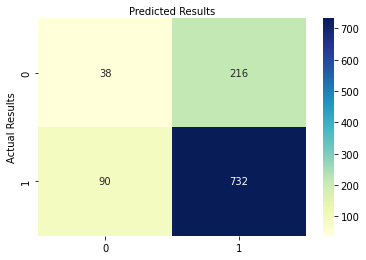

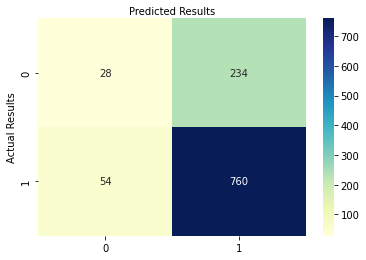

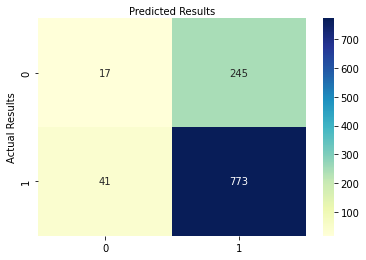

In [ ]:
knn_par_topic, knn_topic = knn_classifier(X_train_topic,  y_train_topic, X_valid_topic, y_valid_topic)
knn_par_vector, knn_vector = knn_classifier(X_train_vector,  y_train_vector, X_valid_vector, y_valid_vector)
knn_par_d2v, knn_d2v = knn_classifier(X_train_d2v,  y_train_d2v, X_valid_d2v, y_valid_d2v)

temp = pd.concat([knn_topic,knn_vector,knn_d2v], axis=0, ignore_index=True)
Knn_results = pd.concat([pd.DataFrame({'Embedding': ['Topic Modeling', 'Vectorization sklearn', 'Doc2Vec']}), temp], axis=1) 
Knn_results

### Classifer 2:- Support Vector Machine

**SVM** outperforms the other classification methods when the dataset has class imbalance. SVM also performs very well with noisy or mislabelled datasets

Source: https://www.sciencedirect.com/science/article/pii/S0167739X19300196

The advantages of support vector machines are:

- Effective in high dimensional spaces.
- Still effective in cases where number of dimensions is greater than the number of samples.
- Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.

- If the number of features is much greater than the number of samples, avoid over-fitting in choosing Kernel functions and regularization term is crucial.

Source: https://scikit-learn.org/stable/modules/svm.html

In [ ]:
def svm_classifier(feature_matrix_train,  label_matrix_train, feature_matrix_valid, label_matrix_valid):

  # Initialise the results dictionary to store the scores
  results = {}
  ## Default SVM model
  SVC_model_default = SVC()
  SVC_model_default.fit(feature_matrix_train,  label_matrix_train)

  # Take the predictions
  y_pred_svc_train = SVC_model_default.predict(feature_matrix_train)
  y_pred_svc_valid = SVC_model_default.predict(feature_matrix_valid)

  # Find the accuracies
  results['Accuracy Default Train'] = accuracy_score(y_pred_svc_train, label_matrix_train)
  results['f1 Default Train'] = f1_score(y_pred_svc_train, label_matrix_train)
  results['Accuracy Default Valid'] = accuracy_score(y_pred_svc_valid, label_matrix_valid)
  results['f1 Default Valid'] = f1_score(y_pred_svc_valid, label_matrix_valid)

  ## Hyperparameter tuning 
  '''
  For SVM with Radial Basis Function (RBF) kernel:
  - The parameter C ('penallty of each misclassified data') : trades off misclassification of training examples against simplicity of the decision surface (low C makes the decision boundary to have lage margin and more missclasification in the training set, high C aims at classifying all training examples correctly (overfitting)).
  - The parameter gamma : defines how much influence a single training example has. Low values of gamma results in more points being grouped together. For high values of gamma, the points need to be very close to each other in order to be considered in the same group. -> Very large gamma can overfit (smaller gamma -> more generalised models)
  Source: https://scikit-learn.org/stable/modules/svm.html
  Source: https://towardsdatascience.com/hyperparameter-tuning-for-support-vector-machines-c-and-gamma-parameters-6a5097416167
  '''

  # Intentifying the ranges to examine
  param_grid = {'kernel' : [ 'rbf','linear'],  
                'C' : [1.0, 0.1,0.01],
                'gamma' : [0.1,0.01,0.001,0.0001]
              } 

  # defining parameter range
  svm = SVC()
  grid = GridSearchCV(svm, param_grid, cv=3, scoring='accuracy', return_train_score=True, verbose=1, n_jobs=6)

  # Fitting the model for grid search
  grid_search=grid.fit(feature_matrix_train, label_matrix_train)

  grid_search.best_params_

  # Initialising the optimised model
  svm_best = SVC(kernel= grid_search.best_params_['kernel'], C= grid_search.best_params_['C'], gamma= grid_search.best_params_['gamma'])

  # Fitting the optimised model
  svm_best.fit(feature_matrix_train,  label_matrix_train)

  # Take the predictions
  y_pred_svm_train = svm_best.predict(feature_matrix_train)
  y_pred_svm_valid = svm_best.predict(feature_matrix_valid)

  # Find the accuracies
  results['Accuracy Optimised Train'] = accuracy_score(y_pred_svm_train, label_matrix_train)
  results['Accuracy Optimised Valid'] = accuracy_score(y_pred_svm_valid, label_matrix_valid)
  results['f1 Optimised Train'] = f1_score(y_pred_svm_train, label_matrix_train)
  results['f1 Optimised Valid'] = f1_score(y_pred_svm_valid, label_matrix_valid)

  df = pd.DataFrame(results, index=['SVM Classifier'])

  print('Classification report for training set at the optimised SVM Classifier')
  print('======================================================================')
  print(classification_report(label_matrix_train,y_pred_svm_train))

  print('Classification report for validation set at the optimised SVM Classifier')
  print('========================================================================')
  print(classification_report(label_matrix_valid,y_pred_svm_valid))


  cm = confusion_matrix(label_matrix_valid,y_pred_svm_valid)
  TN = cm[0][0]
  FP = cm[0][1]
  FN = cm[1][0]
  TP = cm[1][1]

  # Visualizing the Confusion Matrix
  fig = plt.figure()
  ax1 = fig.add_subplot(1,1,1)
  sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.ylabel('Actual Results')
  plt.xlabel('Predicted Results')
  ax1.xaxis.set_label_position("top")

  print("Model's Accuracy:", (TP+TN)/(TN+TP+FN+FP))
  print("Model's Misclassification:", (FP+FN)/(TN+TP+FN+FP))
  print("Model's Specificity:", TN/(FP+TN))
  print("Model's Sensitivity:", TP/(TP+FN))

  print("F1 score:", f1_score(label_matrix_valid,y_pred_svm_valid))

  return (grid_search.best_params_, df)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Classification report for training set at the optimised SVM Classifier
              precision    recall  f1-score   support

           0       0.81      0.02      0.04      2287
           1       0.77      1.00      0.87      7392

    accuracy                           0.77      9679
   macro avg       0.79      0.51      0.45      9679
weighted avg       0.78      0.77      0.67      9679

Classification report for validation set at the optimised SVM Classifier
              precision    recall  f1-score   support

           0       0.62      0.02      0.04       254
           1       0.77      1.00      0.87       822

    accuracy                           0.77      1076
   macro avg       0.70      0.51      0.45      1076
weighted avg       0.73      0.77      0.67      1076

Model's Accuracy: 0.7657992565055762
Model's Misclassification: 0.2342007434944238
Model's Specificity: 0.01968503937007874
Model's Sensitivi

,Embedding,Accuracy Default Train,f1 Default Train,Accuracy Default Valid,f1 Default Valid,Accuracy Optimised Train,Accuracy Optimised Valid,f1 Optimised Train,f1 Optimised Valid
0,Topic Modeling,0.788615,0.878142,0.767658,0.863537,0.767228,0.765799,0.867603,0.866667
1,Vectorization sklearn,0.772497,0.870486,0.757435,0.861832,0.830251,0.773234,0.899848,0.867391
2,Doc2Vec,0.766298,0.867425,0.756506,0.861376,0.764542,0.756506,0.866561,0.861376


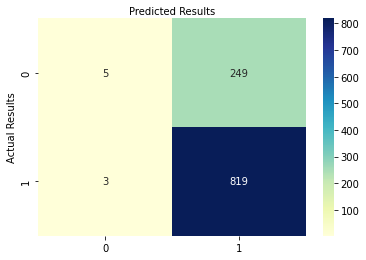

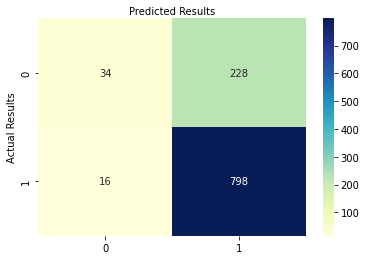

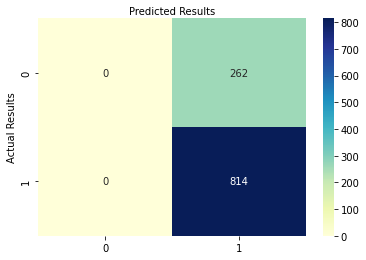

In [ ]:
svm_par_topic, svm_topic = svm_classifier(X_train_topic,  y_train_topic, X_valid_topic, y_valid_topic)
svm_par_vector, svm_vector = svm_classifier(X_train_vector,  y_train_vector, X_valid_vector, y_valid_vector)
svm_par_d2v, svm_d2v = svm_classifier(X_train_d2v,  y_train_d2v, X_valid_d2v, y_valid_d2v)

temp = pd.concat([svm_topic,svm_vector,svm_d2v], axis=0, ignore_index=True)
Svm_results = pd.concat([pd.DataFrame({'Embedding': ['Topic Modeling', 'Vectorization sklearn', 'Doc2Vec']}), temp], axis=1) 
Svm_results

### Classifer 3:- Logistic regression 

In [ ]:
def logistic_classifier(feature_matrix_train,  label_matrix_train, feature_matrix_valid, label_matrix_valid):

    # Initialise the results dictionary to store the scores
    results = {}

    # Initialise and train baseline logistic model 
    log_model_default = LogisticRegression()
    log_model_default.fit(feature_matrix_train,  label_matrix_train) 

    ## Choosing the right threshold
    # Getting the thesholds, fpr and tpr score
    Y_probs_valid =log_model_default.predict_proba(feature_matrix_valid)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(label_matrix_valid,Y_probs_valid)

    # Finding the appropriate threshold
    threshold = thresholds[np.argmax(tpr - fpr)]

    # Take the predictions
    Y_probs_train =log_model_default.predict_proba(feature_matrix_train)[:,1]
    y_pred_log_train = np.where(Y_probs_train > threshold, 1, 0)
    y_pred_log_valid = np.where(Y_probs_valid > threshold, 1, 0)

    # Find the accuracies
    results['Accuracy Default Train'] = accuracy_score(y_pred_log_train, label_matrix_train)
    results['f1 Default Train'] = f1_score(y_pred_log_train, label_matrix_train)
    results['Accuracy Default Valid'] = accuracy_score(y_pred_log_valid, label_matrix_valid)
    results['f1 Default Valid'] = f1_score(y_pred_log_valid, label_matrix_valid)

    ## Hyperparameter tuning
    '''
    Solver: 
    - sag: Stochastic Average Gradient descent. A variation of gradient descent and incremental aggregated gradient approaches that uses a random sample of previous gradient values. Fast for big datasets.
    - saga: Extension of sag that also allows for L1 regularization. Should generally train faster than sag.
    - lbfgs: It approximates the second derivative matrix updates with gradient evaluations. It stores only the last few updates, so it saves memory. It isn't super fast with large data sets.
    Penalty: 
    - L1 regularization: Lasso Regression 
    - L2 regularization: Ridge Regression
    - elasticnet: both L1 and L2 penalty terms are added
    Penalty power:

    Sources: https://towardsdatascience.com/dont-sweat-the-solver-stuff-aea7cddc3451 , https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c, https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    '''

    param_grid = [    
        {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
        'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'solver' : ['sag','saga'] 
        }
    ]

    # defining parameter range
    lgr = LogisticRegression()
    grid = GridSearchCV(lgr, param_grid, cv=5, scoring='accuracy', return_train_score=True, verbose=1, n_jobs=6)

    # Fitting the model for grid search
    grid_search=grid.fit(feature_matrix_train, label_matrix_train)

    grid_search.best_params_

    # Initialise and train optimal logistic model 
    log_best = LogisticRegression(solver=grid_search.best_params_['solver'], penalty=grid_search.best_params_['penalty'], C=grid_search.best_params_['C'])
    log_best.fit(feature_matrix_train,  label_matrix_train) 

    ## Choosing the right threshold
    # Getting the thesholds, fpr and tpr score
    Y_probs_valid =log_best.predict_proba(feature_matrix_valid)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(label_matrix_valid,Y_probs_valid)

    # Finding the appropriate threshold
    threshold = thresholds[np.argmax(tpr - fpr)]

    # Take the predictions
    Y_probs_train =log_best.predict_proba(feature_matrix_train)[:,1]
    y_pred_log_train = np.where(Y_probs_train > threshold, 1, 0)
    y_pred_log_valid = np.where(Y_probs_valid > threshold, 1, 0)

    # Find the accuracies
    results['Accuracy Optimised Train'] = accuracy_score(y_pred_log_train, label_matrix_train)
    results['Accuracy Optimised Valid'] = accuracy_score(y_pred_log_valid, label_matrix_valid)
    results['f1 Optimised Train'] = f1_score(y_pred_log_train, label_matrix_train)
    results['f1 Optimised Valid'] = f1_score(y_pred_log_valid, label_matrix_valid)

    df = pd.DataFrame(results, index=['Logistic regression Classifier'])

    print('Classification report for training set at the optimised Logistic regression Classifier')
    print('======================================================================================')
    print(classification_report(label_matrix_train,y_pred_log_train))

    print('Classification report for validation set at the optimised Logistic regression Classifier')
    print('========================================================================================')
    print(classification_report(label_matrix_valid,y_pred_log_valid))


    cm = confusion_matrix(label_matrix_valid,y_pred_log_valid)
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]

    # Visualizing the Confusion Matrix
    fig = plt.figure()
    ax1 = fig.add_subplot(1,1,1)
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
    plt.ylabel('Actual Results')
    plt.xlabel('Predicted Results')
    ax1.xaxis.set_label_position("top")

    print("Model's Accuracy:", (TP+TN)/(TN+TP+FN+FP))
    print("Model's Misclassification:", (FP+FN)/(TN+TP+FN+FP))
    print("Model's Specificity:", TN/(FP+TN))
    print("Model's Sensitivity:", TP/(TP+FN))

    print("F1 score:", f1_score(label_matrix_valid,y_pred_log_valid))

    return (grid_search.best_params_, df)

Fitting 5 folds for each of 56 candidates, totalling 280 fits
Classification report for training set at the optimised Logistic regression Classifier
              precision    recall  f1-score   support

           0       0.49      0.45      0.47      2287
           1       0.83      0.85      0.84      7392

    accuracy                           0.76      9679
   macro avg       0.66      0.65      0.65      9679
weighted avg       0.75      0.76      0.75      9679

Classification report for validation set at the optimised Logistic regression Classifier
              precision    recall  f1-score   support

           0       0.29      0.55      0.38       254
           1       0.81      0.58      0.68       822

    accuracy                           0.57      1076
   macro avg       0.55      0.56      0.53      1076
weighted avg       0.68      0.57      0.61      1076

Model's Accuracy: 0.5743494423791822
Model's Misclassification: 0.4256505576208178
Model's Specificity: 0.54

,Embedding,Accuracy Default Train,f1 Default Train,Accuracy Default Valid,f1 Default Valid,Accuracy Optimised Train,Accuracy Optimised Valid,f1 Optimised Train,f1 Optimised Valid
0,Topic Modeling,0.737163,0.826656,0.710967,0.811629,0.757723,0.574349,0.843280,0.676554
1,Vectorization sklearn,0.880256,0.915309,0.723048,0.799462,0.661329,0.642193,0.738137,0.717949
2,Doc2Vec,0.634053,0.730400,0.625465,0.719944,0.235458,0.243494,0.000000,0.000000


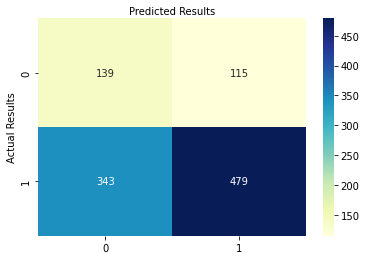

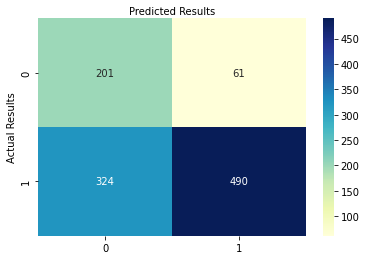

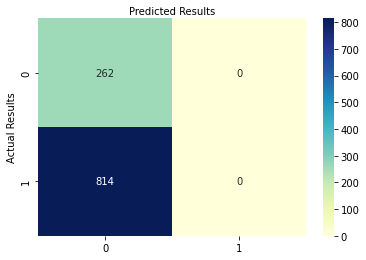

In [ ]:
log_par_topic, log_topic = logistic_classifier(X_train_topic,  y_train_topic, X_valid_topic, y_valid_topic)
log_par_vector, log_vector = logistic_classifier(X_train_vector,  y_train_vector, X_valid_vector, y_valid_vector)
log_par_d2v, log_d2v = logistic_classifier(X_train_d2v,  y_train_d2v, X_valid_d2v, y_valid_d2v)

temp = pd.concat([log_topic,log_vector,log_d2v], axis=0, ignore_index=True)
log_results = pd.concat([pd.DataFrame({'Embedding': ['Topic Modeling', 'Vectorization sklearn', 'Doc2Vec']}), temp], axis=1) 
log_results

### Classifer 4:- Naive Bayes Classifiers


Naive Bayes classifier doesn't take into account the order of words appeared in a document (statsquest)

- Multinomial Naive Bayes: This is mostly used for document classification problem. The features/predictors used by the classifier are the frequency of the words present in the document.
- Bernoulli Naive Bayes: This is similar to the multinomial naive bayes but the predictors are boolean variables. Take only values yes or no, for example if a word occurs in the text or not.
- Gaussian Naive Bayes: When the predictors take up a continuous value and are not discrete, we assume that these values are sampled from a gaussian distribution.

Sources: https://towardsdatascience.com/naive-bayes-classifier-81d512f50a7c , https://www.analyticsvidhya.com/blog/2021/01/gaussian-naive-bayes-with-hyperpameter-tuning/

### Classifer 4.1:- Gaussian Naive Bayes Classifiers

In [ ]:
def gaussian_bayes(feature_matrix_train,  label_matrix_train, feature_matrix_valid, label_matrix_valid):

    # Initialise the results dictionary to store the scores
    results = {}

    #  Initializing the defauld model 
    model_gnb_default = GaussianNB()  
    model_gnb_default.fit(feature_matrix_train, label_matrix_train)


    # Take the predictions
    y_pred_gnb_train = model_gnb_default.predict(feature_matrix_train)
    y_pred_gnb_valid = model_gnb_default.predict(feature_matrix_valid)


    # Find the accuracies
    results['Accuracy Default Train'] = accuracy_score(y_pred_gnb_train, label_matrix_train)
    results['f1 Default Train'] = f1_score(y_pred_gnb_train, label_matrix_train)
    results['Accuracy Default Valid'] = accuracy_score(y_pred_gnb_valid, label_matrix_valid)
    results['f1 Default Valid'] = f1_score(y_pred_gnb_valid, label_matrix_valid)

    ## Hyperparameter tuning
    param_grid = [ {'var_smoothing': np.logspace(0,-9, num=10)} ] 

    # defining parameter range
    g_NB = GaussianNB()
    grid = GridSearchCV(g_NB, param_grid, cv=5, scoring='accuracy', return_train_score=True, verbose=1, n_jobs=6)

    # Fitting the model for grid search
    g_NB_best=grid.fit(feature_matrix_train, label_matrix_train)

    # Take the predictions
    y_pred_gnb_train = g_NB_best.predict(feature_matrix_train)
    y_pred_gnb_valid = g_NB_best.predict(feature_matrix_valid)

    # Find the accuracies
    results['Accuracy Optimised Train'] = accuracy_score(y_pred_gnb_train, label_matrix_train)
    results['Accuracy Optimised Valid'] = accuracy_score(y_pred_gnb_valid, label_matrix_valid)
    results['f1 Optimised Train'] = f1_score(y_pred_gnb_train, label_matrix_train)
    results['f1 Optimised Valid'] = f1_score(y_pred_gnb_valid, label_matrix_valid)

    df = pd.DataFrame(results, index=['Gaussian Naive Bayes Classifier'])

    print('Classification report for training set at the optimised Gaussian Naive Bayes')
    print('===========================================================')
    print(classification_report(label_matrix_train,y_pred_gnb_train))

    print('Classification report for validation set at the optimised Gaussian Naive Bayes')
    print('===========================================================')
    print(classification_report(label_matrix_valid,y_pred_gnb_valid))

    cm = confusion_matrix(label_matrix_valid,y_pred_gnb_valid)
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]

    # Visualizing the Confusion Matrix
    fig = plt.figure()
    ax1 = fig.add_subplot(1,1,1)
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
    plt.ylabel('Actual Results')
    plt.xlabel('Predicted Results')
    ax1.xaxis.set_label_position("top")

    print("Model's Accuracy:", (TP+TN)/(TN+TP+FN+FP))
    print("Model's Misclassification:", (FP+FN)/(TN+TP+FN+FP))
    print("Model's Specificity:", TN/(FP+TN))
    print("Model's Sensitivity:", TP/(TP+FN))

    print("F1 score:", f1_score(label_matrix_valid,y_pred_gnb_valid))

    return (g_NB_best, df)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Classification report for training set at the optimised Gaussian Naive Bayes
              precision    recall  f1-score   support

           0       0.52      0.22      0.31      2287
           1       0.79      0.94      0.86      7392

    accuracy                           0.77      9679
   macro avg       0.66      0.58      0.58      9679
weighted avg       0.73      0.77      0.73      9679

Classification report for validation set at the optimised Gaussian Naive Bayes
              precision    recall  f1-score   support

           0       0.38      0.08      0.13       254
           1       0.77      0.96      0.86       822

    accuracy                           0.75      1076
   macro avg       0.57      0.52      0.49      1076
weighted avg       0.68      0.75      0.68      1076

Model's Accuracy: 0.7518587360594795
Model's Misclassification: 0.24814126394052044
Model's Specificity: 0.07874015748031496
Mode

,Embedding,Accuracy Default Train,f1 Default Train,Accuracy Default Valid,f1 Default Valid,Accuracy Optimised Train,Accuracy Optimised Valid,f1 Optimised Train,f1 Optimised Valid
0,Topic Modeling,0.475772,0.515470,0.698885,0.812717,0.767538,0.751859,0.860387,0.855285
1,Vectorization sklearn,0.894927,0.926213,0.718401,0.813309,0.764542,0.756506,0.866561,0.861376
2,Doc2Vec,0.441575,0.482428,0.425651,0.453097,0.441471,0.425651,0.482184,0.453097


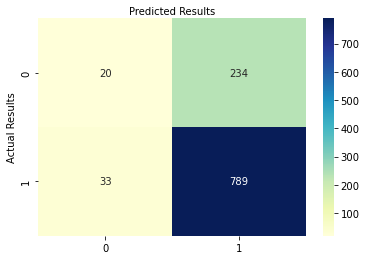

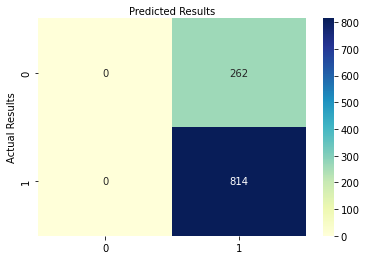

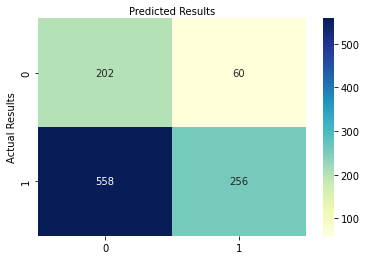

In [ ]:
gnb_par_topic, gnb_topic = gaussian_bayes(X_train_topic,  y_train_topic, X_valid_topic, y_valid_topic)
gnb_par_vector, gnb_vector = gaussian_bayes(X_train_vector.toarray(),  y_train_vector, X_valid_vector.toarray(), y_valid_vector)
gnb_par_d2v, gnb_d2v = gaussian_bayes(X_train_d2v,  y_train_d2v, X_valid_d2v, y_valid_d2v)

temp = pd.concat([gnb_topic,gnb_vector,gnb_d2v], axis=0, ignore_index=True)
gnb_results = pd.concat([pd.DataFrame({'Embedding': ['Topic Modeling', 'Vectorization sklearn', 'Doc2Vec']}), temp], axis=1) 
gnb_results

### Classifer 4.2:- Multinomial Naive Bayes Classifiers

In [ ]:
def multinomial_bayes(feature_matrix_train,  label_matrix_train, feature_matrix_valid, label_matrix_valid):

    # Initialise the results dictionary to store the scores
    results = {}

    # Initializing the defauld model 
    model_mn_default = MultinomialNB()  
    model_mn_default.fit(feature_matrix_train, label_matrix_train)

    # Take the predictions
    y_pred_mn_train = model_mn_default.predict(feature_matrix_train)
    y_pred_mn_valid = model_mn_default.predict(feature_matrix_valid)


    # Find the accuracies
    results['Accuracy Default Train'] = accuracy_score(y_pred_mn_train, label_matrix_train)
    results['f1 Default Train'] = f1_score(y_pred_mn_train, label_matrix_train)
    results['Accuracy Default Valid'] = accuracy_score(y_pred_mn_valid, label_matrix_valid)
    results['f1 Default Valid'] = f1_score(y_pred_mn_valid, label_matrix_valid)

    # Creating the rest of the columns 
    results['Accuracy Optimised Train'] = '-'
    results['Accuracy Optimised Valid'] = '-'
    results['f1 Optimised Train'] = '-'
    results['f1 Optimised Valid'] = '-'

    df = pd.DataFrame(results, index=['Multinomial Naive Bayes Classifier'])

    print('Classification report for training set at the Multinomial Naive Bayes')
    print('=====================================================================')
    print(classification_report(label_matrix_train,y_pred_mn_train))

    print('Classification report for validation set at the Multinomial Naive Bayes')
    print('=======================================================================')
    print(classification_report(label_matrix_valid,y_pred_mn_valid))


    cm = confusion_matrix(label_matrix_valid,y_pred_mn_valid)
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]

    # Visualizing the Confusion Matrix
    fig = plt.figure()
    ax1 = fig.add_subplot(1,1,1)
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
    plt.ylabel('Actual Results')
    plt.xlabel('Predicted Results')
    ax1.xaxis.set_label_position("top")

    print("Model's Accuracy:", (TP+TN)/(TN+TP+FN+FP))
    print("Model's Misclassification:", (FP+FN)/(TN+TP+FN+FP))
    print("Model's Specificity:", TN/(FP+TN))
    print("Model's Sensitivity:", TP/(TP+FN))
    print("F1 score:", f1_score(label_matrix_valid,y_pred_mn_valid))

    return df

Classification report for training set at the Multinomial Naive Bayes
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2287
           1       0.76      1.00      0.87      7392

    accuracy                           0.76      9679
   macro avg       0.38      0.50      0.43      9679
weighted avg       0.58      0.76      0.66      9679

Classification report for validation set at the Multinomial Naive Bayes
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       254
           1       0.76      1.00      0.87       822

    accuracy                           0.76      1076
   macro avg       0.38      0.50      0.43      1076
weighted avg       0.58      0.76      0.66      1076

Model's Accuracy: 0.7639405204460966
Model's Misclassification: 0.23605947955390336
Model's Specificity: 0.0
Model's Sensitivity: 1.0
F1 score: 0.8661749209694415
Classification report for training set at

,Embedding,Accuracy Default Train,f1 Default Train,Accuracy Default Valid,f1 Default Valid,Accuracy Optimised Train,Accuracy Optimised Valid,f1 Optimised Train,f1 Optimised Valid
0,Topic Modeling,0.763715,0.866030,0.763941,0.866175,-,-,-,-
1,Vectorization sklearn,0.876950,0.920137,0.776952,0.860140,-,-,-,-


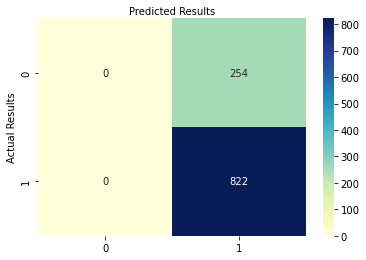

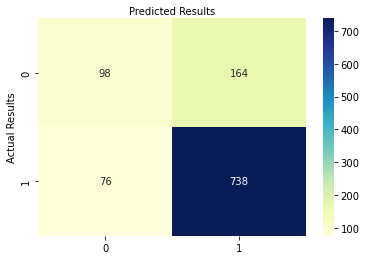

In [ ]:
mnb_topic = multinomial_bayes(X_train_topic,  y_train_topic, X_valid_topic, y_valid_topic)
mnb_vector = multinomial_bayes(X_train_vector,  y_train_vector, X_valid_vector, y_valid_vector)
#mnb_d2v = multinomial_bayes(X_train_d2v,  y_train_d2v, X_valid_d2v, y_valid_d2v)

temp = pd.concat([mnb_topic,mnb_vector], axis=0, ignore_index=True)
mnb_results = pd.concat([pd.DataFrame({'Embedding': ['Topic Modeling', 'Vectorization sklearn']}), temp], axis=1) 
mnb_results


### Classifer 4.3:- Ridge Classifier

In [ ]:
def ridge(feature_matrix_train,  label_matrix_train, feature_matrix_valid, label_matrix_valid):

    # Initialise the results dictionary to store the scores
    results = {}

    #  Initializing the defauld model 
    model_rc_default = RidgeClassifier(random_state=7)  
    model_rc_default.fit(feature_matrix_train, label_matrix_train)


    # Take the predictions
    y_pred_rc_train = model_rc_default.predict(feature_matrix_train)
    y_pred_rc_valid = model_rc_default.predict(feature_matrix_valid)


    # Find the accuracies
    results['Accuracy Default Train'] = accuracy_score(y_pred_rc_train, label_matrix_train)
    results['f1 Default Train'] = f1_score(y_pred_rc_train, label_matrix_train)
    results['Accuracy Default Valid'] = accuracy_score(y_pred_rc_valid, label_matrix_valid)
    results['f1 Default Valid'] = f1_score(y_pred_rc_valid, label_matrix_valid)

    # defining parameter range
    rc_cv = RidgeClassifierCV(alphas=np.power([10]*10,np.arange(-5,5),dtype=float))
    # Fitting the model for grid search
    rc_cv_best=rc_cv.fit(feature_matrix_train, label_matrix_train)

    # Take the predictions
    y_pred_rc_cv_train = rc_cv_best.predict(feature_matrix_train)
    y_pred_rc_cv_valid = rc_cv_best.predict(feature_matrix_valid)

    # Find the accuracies
    results['Accuracy Optimised Train'] = accuracy_score(y_pred_rc_cv_train, label_matrix_train)
    results['Accuracy Optimised Valid'] = accuracy_score(y_pred_rc_cv_valid, label_matrix_valid)
    results['f1 Optimised Train'] = f1_score(y_pred_rc_cv_train, label_matrix_train)
    results['f1 Optimised Valid'] = f1_score(y_pred_rc_cv_valid, label_matrix_valid)

    df = pd.DataFrame(results, index=['Ridge Classifier'])

    print('Classification report for training set at the optimised Ridge Classifier')
    print('===========================================================')
    print(classification_report(label_matrix_train,y_pred_rc_cv_train))

    print('Classification report for validation set at the optimised Ridge Classifier')
    print('===========================================================')
    print(classification_report(label_matrix_valid,y_pred_rc_cv_valid))

    cm = confusion_matrix(label_matrix_valid,y_pred_rc_cv_valid)
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]

    # Visualizing the Confusion Matrix
    fig = plt.figure()
    ax1 = fig.add_subplot(1,1,1)
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
    plt.ylabel('Actual Results')
    plt.xlabel('Predicted Results')
    ax1.xaxis.set_label_position("top")

    print("Model's Accuracy:", (TP+TN)/(TN+TP+FN+FP))
    print("Model's Misclassification:", (FP+FN)/(TN+TP+FN+FP))
    print("Model's Specificity:", TN/(FP+TN))
    print("Model's Sensitivity:", TP/(TP+FN))

    print("F1 score:", f1_score(label_matrix_valid,y_pred_rc_cv_valid))

    return (rc_cv_best.get_params ,df)

Classification report for training set at the optimised Ridge Classifier
              precision    recall  f1-score   support

           0       0.65      0.16      0.26      2287
           1       0.79      0.97      0.87      7392

    accuracy                           0.78      9679
   macro avg       0.72      0.57      0.57      9679
weighted avg       0.76      0.78      0.73      9679

Classification report for validation set at the optimised Ridge Classifier
              precision    recall  f1-score   support

           0       0.29      0.48      0.36       254
           1       0.80      0.64      0.71       822

    accuracy                           0.60      1076
   macro avg       0.54      0.56      0.53      1076
weighted avg       0.68      0.60      0.63      1076

Model's Accuracy: 0.5985130111524164
Model's Misclassification: 0.40148698884758366
Model's Specificity: 0.48031496062992124
Model's Sensitivity: 0.635036496350365
F1 score: 0.7073170731707317
Class

,Embedding,Accuracy Default Train,f1 Default Train,Accuracy Default Valid,f1 Default Valid,Accuracy Optimised Train,Accuracy Optimised Valid,f1 Optimised Train,f1 Optimised Valid
0,Topic Modeling,0.776010,0.869915,0.738848,0.838413,0.781796,0.598513,0.871984,0.707317
1,Vectorization sklearn,0.993284,0.995625,0.700743,0.800000,0.782002,0.765799,0.875015,0.865528
2,Doc2Vec,0.764025,0.866214,0.756506,0.861376,0.764025,0.756506,0.866214,0.861376


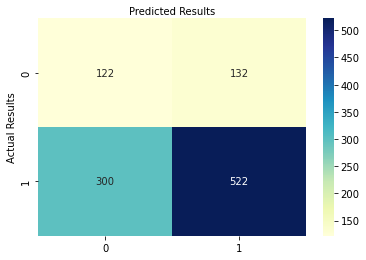

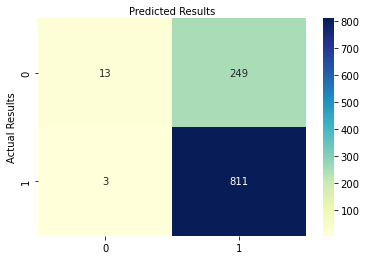

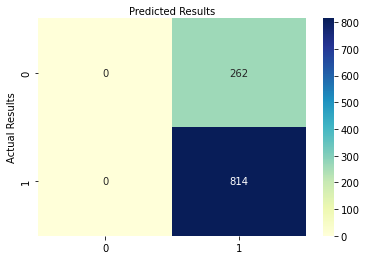

In [ ]:
rc_par_topic, rc_topic = ridge(X_train_topic,  y_train_topic, X_valid_topic, y_valid_topic)
rc_par_vector, rc_vector = ridge(X_train_vector,  y_train_vector, X_valid_vector, y_valid_vector)
rc_par_d2v, rc_d2v = ridge(X_train_d2v,  y_train_d2v, X_valid_d2v, y_valid_d2v)

temp = pd.concat([rc_topic,rc_vector,rc_d2v], axis=0, ignore_index=True)
rc_results = pd.concat([pd.DataFrame({'Embedding': ['Topic Modeling', 'Vectorization sklearn', 'Doc2Vec']}), temp], axis=1) 
rc_results

# **Applying Deep Learning by using Tensorflow**

#### For the next steps in our analysis in order to classify the reviews, we applied Deep Learning (DL) models.

#### Below you can see the apporaches that we followed:

#### 1. Keras Tokenizer, by implenting on the cleaned dataset
#### 2. Implemented basic LSTM & LSTM with Conv-1D to Topic Modeling (TM)
#### 3. Bert pre-trained dataset to Topic Modeling(TM)

##### Sources:
## **Keras Tokenizer**
 - `https://www.tensorflow.org/tutorials/keras/text_classification`
 - `https://www.tensorflow.org/text/tutorials/text_classification_rnn`
 - `https://www.tensorflow.org/text/guide/word_embeddings`
## **Topic Modeling with LSTM & RNN/CNN**
 - `https://ieeexplore.ieee.org/document/8632592` -> (Jingjing Cai, Jianping Li, Wei Li, Ji Wang, 2018)
## **Bert**
 - `https://www.tensorflow.org/text/tutorials/classify_text_with_bert` 
 - `https://link.springer.com/chapter/10.1007/978-3-030-32381-3_16` -> (Chi Sun, Xipeng Qiu, Yige Xu, Xuanjing Huang, 2019)

# 1. Keras Tokenizer

In [ ]:
# count unique words
def counter_word(text_col):
  count = Counter()
  for text in text_col.values:
    for word in text.split():
      count[word] += 1
  return count

counter = counter_word(train_df.cleaned_review)

In [ ]:
len(counter)

In [ ]:
counter.most_common(5)

In [ ]:
num_unique_words = len(counter)

In [ ]:
# spliting into train and validation

df_train, df_val = train_test_split(train_df, test_size = 0.1,stratify = train_df['helpfulness_cat'], random_state = 7)

In [ ]:
# split text and labels
train_sentences = df_train.cleaned_review.to_numpy()
train_labels = df_train.helpfulness_cat.to_numpy()
val_sentences = df_val.cleaned_review.to_numpy()
val_labels = df_val.helpfulness_cat.to_numpy()

In [ ]:
print(train_sentences)
print(train_labels)
print(val_sentences)
print(val_labels)

### Applying tokenizer

In [ ]:
# vectorize a text corpus by tuning each text into a sequence of integers
tokenizer = Tokenizer(num_words = num_unique_words)
tokenizer.fit_on_texts(train_sentences) # fit only to training

In [ ]:
# each word has a unique index
word_index = tokenizer.word_index

### Converting the text into sequence

In [ ]:
# each word has a unique index
word_index = tokenizer.word_index

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
val_sequences = tokenizer.texts_to_sequences(val_sentences)

In [ ]:
print(train_sentences[10:15])
print(train_sequences[10:15])

In [ ]:
len(train_sentences[10:15]) == len(train_sequences[10:15])

### For every sequence we need the same length.
##### Use of padding to make sure about the length of every sequence.

In [ ]:
# max number of words in a sequence
max_length = 50 # might need change

train_padded = pad_sequences(train_sequences, maxlen = max_length, padding = "post", truncating = "post")
val_padded = pad_sequences(val_sequences, maxlen = max_length, padding = "post", truncating = "post")
train_padded.shape, val_padded.shape

In [ ]:
train_padded[5]

In [ ]:
print(train_sentences[2])
print(train_sequences[2])
print(train_padded[2])

### Checking the above pre-process is working by reversing the indices

In [ ]:
# check reversing the indices

# flip( key, value)

reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])

In [ ]:
def decode(sequence):
  return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

In [ ]:
decoded_text = decode(train_sequences[2])

print(train_sequences[2])
print(decoded_text)

### Creating a simple LSTM model and using the `Keras Tokenizer` data

In [ ]:
train_TF = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels))
val_TF = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels))

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_dataset = train_TF.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_TF.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
tf.keras.backend.clear_session()
encoder = TextVectorization()
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
model_LSTM = Sequential([
    encoder,
    Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dense(1, activation = 'sigmoid')
])

In [ ]:
model_LSTM.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history_LSTM = model_LSTM.fit(train_dataset, epochs=10,
                    validation_data=val_dataset,
                    validation_steps=10)

In [ ]:
# ---+ visualising the model
def create_plot(log):
    plt.plot(log.history['accuracy'], label = 'training accuracy', color = 'green')
    plt.plot(log.history['val_accuracy'], label = 'validation accuracy', color = 'red')
    plt.plot(log.history['loss'], label = 'training loss', color = 'blue')
    plt.plot(log.history['val_loss'], label = 'validation loss', color = 'orange')
    plt.title('Training and validation accuracy and loss')
    plt.legend()
    plt.show()
create_plot(history_LSTM)

In [ ]:
y_pred = history_LSTM.predict(X_valid)

In [ ]:
y_pred=np.where(y_pred>=0.5,1,0)

In [ ]:
f1_score(y_valid,y_pred)

## LSTM with Conv-1D layers (optimizing the simple LSTM) by `Keras Tokenizer`

In [ ]:
from keras.layers.normalization.batch_normalization import BatchNormalization
# create the model
embedding_vector_length = 32
cnn_model = Sequential()

# Embedding layer
# Convolution-1D Layer 
# LSTM Layer 
# Dense Layer

cnn_model.add(Embedding(input_dim=num_unique_words, output_dim=embedding_vector_length, input_length=max_length))
cnn_model.add(Conv1D(filters=16, kernel_size=4, padding='valid', activation='relu', activity_regularizer=l1(0.005), kernel_regularizer=L1L2(0.01,0.01)))
cnn_model.add(Dropout(0.5))
cnn_model.add(Conv1D(filters=8, kernel_size=2, padding='valid', activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=5))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.2))
cnn_model.add(LSTM(15,activity_regularizer=l1(0.005),kernel_regularizer=L1L2(0.05,0.05)))
cnn_model.add(BatchNormalization())
cnn_model.add(Flatten())
cnn_model.add(Dense(units=1, activation='sigmoid', activity_regularizer=l1(0.005)))


cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(cnn_model.summary())

history_c=cnn_model.fit(train_padded, train_labels,  epochs=20, batch_size=128,verbose = 1,validation_data=(val_padded, val_labels))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 32)            1421280   
                                                                 
 conv1d (Conv1D)             (None, 47, 16)            2064      
                                                                 
 dropout (Dropout)           (None, 47, 16)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 46, 8)             264       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 9, 8)             0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 9, 8)             32        
 ormalization)                                          

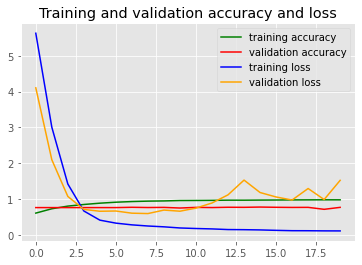

In [ ]:
# ---+ visualising the model
def create_plot(log):
    plt.plot(log.history['accuracy'], label = 'training accuracy', color = 'green')
    plt.plot(log.history['val_accuracy'], label = 'validation accuracy', color = 'red')
    plt.plot(log.history['loss'], label = 'training loss', color = 'blue')
    plt.plot(log.history['val_loss'], label = 'validation loss', color = 'orange')
    plt.title('Training and validation accuracy and loss')
    plt.legend()
    plt.show()
create_plot(history_c)

In [ ]:
y_pred = cnn_model.predict(X_valid)

In [ ]:
y_pred=np.where(y_pred>=0.5,1,0)

In [ ]:
f1_score(y_valid,y_pred)

# 2. Implementing LSTM and optimized LSTM to Topic Modeling outputs

## Pre - processing

In [ ]:
X_train = pd.read_csv('train_topicProb.csv')
y_train = X_train['helpfulness_cat'].to_numpy()
X_train.drop(columns=['Unnamed: 0', 'helpfulness_cat'], inplace=True)
X_valid = pd.read_csv('valid_topicProb.csv')
y_valid = X_valid['helpfulness_cat'].to_numpy()
X_valid.drop(columns=['Unnamed: 0', 'helpfulness_cat'], inplace=True)

In [ ]:
X_train = X_train.to_numpy().reshape(9679,198,1) #reshaping to create the expected inputs for RNNs and CNNs

In [ ]:
X_valid = X_valid.to_numpy().reshape(1076,198,1)

In [ ]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((9679, 198, 1), (1076, 198, 1), (9679,), (1076,))

## Bidirectional LSTM (Tensorflow Guide)

In [ ]:
# cleaning the session

tf.keras.backend.clear_session()
np.random.seed(745)
tf.random.set_seed(658)

In [ ]:
tf.keras.backend.clear_session()
model_LSTM_TM = Sequential([
    Bidirectional(LSTM(64, input_shape=(198,1))),
    Dense(64, activation='relu'),
    Dense(1, activation = 'sigmoid')
])

In [ ]:
model_LSTM_TM.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model_LSTM_TM.fit(x = X_train, y=y_train, epochs=10,
                    validation_data=[X_valid, y_valid],
                    validation_steps=30
)

Epoch 1/10
303/303 [==============================] - 55s 166ms/step - loss: 0.5775 - accuracy: 0.7621 - val_loss: 0.5471 - val_accuracy: 0.7639
Epoch 2/10
303/303 [==============================] - 42s 139ms/step - loss: 0.5474 - accuracy: 0.7637 - val_loss: 0.5466 - val_accuracy: 0.7639
Epoch 3/10
303/303 [==============================] - 44s 147ms/step - loss: 0.5475 - accuracy: 0.7637 - val_loss: 0.5467 - val_accuracy: 0.7639
Epoch 4/10
303/303 [==============================] - 47s 154ms/step - loss: 0.5476 - accuracy: 0.7637 - val_loss: 0.5471 - val_accuracy: 0.7639
Epoch 5/10
303/303 [==============================] - 68s 226ms/step - loss: 0.5477 - accuracy: 0.7637 - val_loss: 0.5497 - val_accuracy: 0.7639
Epoch 6/10
303/303 [==============================] - 53s 176ms/step - loss: 0.5476 - accuracy: 0.7637 - val_loss: 0.5468 - val_accuracy: 0.7639
Epoch 7/10
303/303 [==============================] - 53s 175ms/step - loss: 0.5472 - accuracy: 0.7637 - val_loss: 0.5466 - val_ac

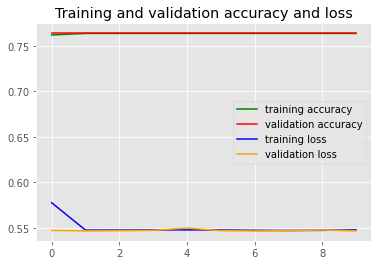

In [ ]:
def create_plot(log):
    plt.plot(log.history['accuracy'], label = 'training accuracy', color = 'green')
    plt.plot(log.history['val_accuracy'], label = 'validation accuracy', color = 'red')
    plt.plot(log.history['loss'], label = 'training loss', color = 'blue')
    plt.plot(log.history['val_loss'], label = 'validation loss', color = 'orange')
    plt.title('Training and validation accuracy and loss')
    plt.legend()
    plt.show()
    
create_plot(history)

In [ ]:
y_pred = model_LSTM_TM.predict(X_valid)

In [ ]:
y_pred=np.where(y_pred>=0.5,1,0)

In [ ]:
f1_score(y_valid,y_pred)

0.8661749209694415

## LSTM - CONV-1D (from paper)

In [ ]:
# cleaning the session

tf.keras.backend.clear_session()
np.random.seed(745)
tf.random.set_seed(658)

In [ ]:
# create the model
tf.keras.backend.clear_session()
RNN_CNN_tm = Sequential([
Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(198,1)),
MaxPooling1D(pool_size=2),
LSTM(75),
Dense(20, activation='relu'),
Dense(1, activation='sigmoid')])

In [ ]:
RNN_CNN_tm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
RNN_CNN_tm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 198, 32)           128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 99, 32)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 75)                32400     
                                                                 
 dense (Dense)               (None, 20)                1520      
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 34,069
Trainable params: 34,069
Non-trainable params: 0
____________________________________________________

In [ ]:
history= RNN_CNN_tm.fit(X_train, y_train, validation_data=[X_valid,y_valid],epochs=10)

Epoch 1/10
303/303 [==============================] - 24s 73ms/step - loss: 0.5549 - accuracy: 0.7633 - val_loss: 0.5473 - val_accuracy: 0.7639
Epoch 2/10
303/303 [==============================] - 23s 76ms/step - loss: 0.5473 - accuracy: 0.7637 - val_loss: 0.5488 - val_accuracy: 0.7639
Epoch 3/10
303/303 [==============================] - 24s 78ms/step - loss: 0.5402 - accuracy: 0.7637 - val_loss: 0.5469 - val_accuracy: 0.7639
Epoch 4/10
303/303 [==============================] - 22s 73ms/step - loss: 0.5331 - accuracy: 0.7637 - val_loss: 0.5482 - val_accuracy: 0.7639
Epoch 5/10
303/303 [==============================] - 22s 73ms/step - loss: 0.5323 - accuracy: 0.7637 - val_loss: 0.5460 - val_accuracy: 0.7639
Epoch 6/10
303/303 [==============================] - 22s 73ms/step - loss: 0.5334 - accuracy: 0.7637 - val_loss: 0.5494 - val_accuracy: 0.7639
Epoch 7/10
303/303 [==============================] - 22s 72ms/step - loss: 0.5331 - accuracy: 0.7637 - val_loss: 0.5479 - val_accuracy:

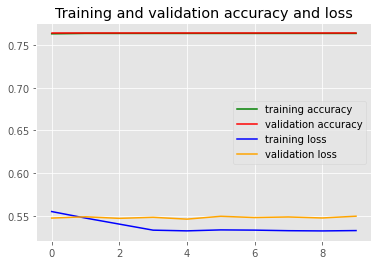

In [ ]:
create_plot(history)

In [ ]:
y_pred = RNN_CNN_tm.predict(X_valid)

In [ ]:
y_pred=np.where(y_pred>=0.5,1,0)

In [ ]:
f1_score(y_valid,y_pred)

0.8661749209694415

# 3. Bert

#### BERT is a method of pre-training language representations, meaning that we train a general-purpose "language understanding" model on a large text corpus (like Wikipedia), and then use that model for downstream NLP tasks that we care about (like question answering) (Jacob Devlin, Ming-Wei Chang, Kenton Lee, Kristina Toutanova, 2018).

#### In addition to the masked language model, BERT uses a next sentence prediction task that jointly pre-trains text-pair representations. There are two steps in BERT: pre-training and fine-tuning. During pre-training, the model is trained on unlabeled data over different pre-training tasks (Jacob Devlin, Ming-Wei Chang, Kenton Lee, Kristina Toutanova, 2018).

#### Source: 
 - `https://arxiv.org/abs/1810.04805`
 - `https://www.tensorflow.org/text/tutorials/classify_text_with_bert`
 - `https://www.tensorflow.org/tfmodels/nlp/fine_tune_bert`


## Pre - processing the data in order to implement the pre - trained Bert model

In [ ]:
# splitting the raw data into train and validation dataset

X_train, X_valid, y_train, y_valid = train_test_split(train_df['imdb_user_review'], train_df['helpfulness_cat'], train_size=0.9,stratify=train_df['helpfulness_cat'], random_state=7)

In [ ]:
# cleaning the session

tf.keras.backend.clear_session()
np.random.seed(745)
tf.random.set_seed(658)

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
# Bert Layers
text_input = tf.keras.layers.Input(shape = (), dtype = tf.string, name = 'cleaned_review') 
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
# Neural network layers
l = tf.keras.layers.Dropout(0.1, name = "dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'output')(l)
# use inputs and outputs to construct a final model
model_BERT = tf.keras.Model(inputs = [text_input], outputs = [l])

In [ ]:
model_BERT.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model_BERT.fit(X_train, y_train, validation_data=[X_valid, y_valid], epochs = 5, batch_size = 32) # use the train, val from the split --> raw data

Epoch 1/5
303/303 [==============================] - 4511s 15s/step - loss: 0.5453 - accuracy: 0.7612 - val_loss: 0.5176 - val_accuracy: 0.7658
Epoch 2/5
303/303 [==============================] - 4495s 15s/step - loss: 0.5308 - accuracy: 0.7593 - val_loss: 0.5257 - val_accuracy: 0.7602
Epoch 3/5
303/303 [==============================] - 4463s 15s/step - loss: 0.5251 - accuracy: 0.7612 - val_loss: 0.5113 - val_accuracy: 0.7630
Epoch 4/5
303/303 [==============================] - 4452s 15s/step - loss: 0.5206 - accuracy: 0.7580 - val_loss: 0.5080 - val_accuracy: 0.7639
Epoch 5/5
303/303 [==============================] - 4448s 15s/step - loss: 0.5187 - accuracy: 0.7573 - val_loss: 0.5068 - val_accuracy: 0.7621


In [ ]:
y_pred = model_BERT.predict(X_valid)

In [ ]:
y_pred=np.where(y_pred>=0.5,1,0)

In [ ]:
f1_score(y_valid,y_pred)

0.8625134264232008

### Optimizing the Bert model 
 - `https://www.tensorflow.org/tfmodels/nlp/fine_tune_bert`
 - `https://towardsdatascience.com/fine-tuning-bert-for-text-classification-54e7df642894`

In [ ]:
# cleaning the session

tf.keras.backend.clear_session()
np.random.seed(745)
tf.random.set_seed(658)

In [ ]:
# Bert Layers
text_input = tf.keras.layers.Input(shape = (), dtype = tf.string, name = 'cleaned_review')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
# Neural network layers
l = tf.keras.layers.Dropout(0.1, name = "dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'output')(l)
# use inputs and outputs to construct a final model
model_bert = tf.keras.Model(inputs = [text_input], outputs = [l])

In [ ]:
model_bert.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cleaned_review (InputLayer)    [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['cleaned_review[0][0]']         
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [ ]:
epochs = 10
steps_per_epoch = len(X_train)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
model_bert.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
history = model_bert.fit(X_train, y_train, validation_data=[X_valid, y_valid], epochs = epochs)

Epoch 1/10
303/303 [==============================] - 110s 356ms/step - loss: 0.5452 - binary_accuracy: 0.7629 - val_loss: 0.5409 - val_binary_accuracy: 0.7639
Epoch 2/10
303/303 [==============================] - 110s 362ms/step - loss: 0.5461 - binary_accuracy: 0.7628 - val_loss: 0.5408 - val_binary_accuracy: 0.7639
Epoch 3/10
303/303 [==============================] - 114s 376ms/step - loss: 0.5464 - binary_accuracy: 0.7637 - val_loss: 0.5408 - val_binary_accuracy: 0.7639
Epoch 4/10
303/303 [==============================] - 113s 375ms/step - loss: 0.5460 - binary_accuracy: 0.7633 - val_loss: 0.5407 - val_binary_accuracy: 0.7639
Epoch 5/10
303/303 [==============================] - 112s 371ms/step - loss: 0.5452 - binary_accuracy: 0.7627 - val_loss: 0.5406 - val_binary_accuracy: 0.7639
Epoch 6/10
303/303 [==============================] - 114s 376ms/step - loss: 0.5447 - binary_accuracy: 0.7630 - val_loss: 0.5404 - val_binary_accuracy: 0.7639
Epoch 7/10
303/303 [====================

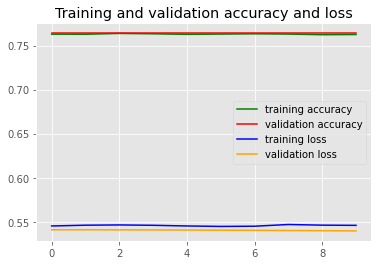

In [ ]:
def create_plot(log):
    plt.plot(log.history['binary_accuracy'], label = 'training accuracy', color = 'green')
    plt.plot(log.history['val_binary_accuracy'], label = 'validation accuracy', color = 'red')
    plt.plot(log.history['loss'], label = 'training loss', color = 'blue')
    plt.plot(log.history['val_loss'], label = 'validation loss', color = 'orange')
    plt.title('Training and validation accuracy and loss')
    plt.legend()
    plt.show()
create_plot(history)

In [ ]:
y_pred = model_bert.predict(X_valid)

34/34 [==============================] - 12s 335ms/step


In [ ]:
y_pred=np.where(y_pred>=0.5,1,0)

In [ ]:
f1_score(y_valid,y_pred)

0.8661749209694415

## Retraining the final model

#### Pre - processing

In [ ]:
from scipy.sparse import vstack

### --- Inspecting the datasets before the combination
print('''
Shapes before combination:
=========================
X_training: {}
y_training: {}
X_validation: {}
y_validation: {}
'''.format(X_train_vector.shape, y_train_vector.shape, X_valid_vector.shape, y_valid_vector.shape))

### --- Combining the datasets before the combination
X_train = vstack([X_train_vector, X_valid_vector])
y_train = np.concatenate([y_train_vector, y_valid_vector])

### --- Inspecting the datasets before the combination
print('''
Shapes after combination:
=========================
X_training: {}
y_training: {}
'''.format(X_train.shape, y_train.shape))


Shapes before combination:
X_training: (9679, 43738)
y_training: (9679,)
X_validation: (1076, 43738)
y_validation: (1076,)


Shapes after combination:
X_training: (10755, 43738)
y_training: (10755,)



## Vectorising the test set

In [ ]:
# passing the 'imdb_user_review' into a variable
imdb_user_review = [i.encode().decode('unicode-escape').replace("\\", "").replace("'","").replace('´','').replace('  ', '').replace('\n', '').replace('\t','').replace('&amp;', 'and') for i in test_df['imdb_user_review']]
imdb_user_review = [unicodedata.normalize('NFKD', i).encode('ascii','ignore').decode() for i in imdb_user_review]

In [ ]:
# removing the stop words and apply cleaning
test_df["cleaned_review"] = test_df['imdb_user_review'].apply(clean)
test_df.head()

,_id,imdb_user_review,cleaned_review
0,610d01fe9a63eb113d2235ac,This is basically a German takeoff on a Sherlo...,basically german takeoff sherlock holmes story...
1,610d01fe9a63eb113d224536,"In January of 1924, director Erich von Strohei...",january director erich von stroheim gathered s...
2,610d01fe9a63eb113d224d14,Silent movies are not for everyone. Neither ar...,silent movies everyone neither subtitles brave...
3,610d01fe9a63eb113d225f17,It so often happens that some films take the l...,often happens films take long way achieve stat...
4,610d01fe9a63eb113d225f1a,I saw this film for the very first time last w...,saw film first time last week tremendously cap...


In [ ]:
# transforming the reviews in a string format
X_test = pd.DataFrame()
X_test["cleaned_review"] = test_df["cleaned_review"].apply(lambda row_text: str(row_text))

In [ ]:
X_test_vector = vectorizer.transform(X_test["cleaned_review"].tolist())

## Multinomial Naive Bayes final model

In [ ]:
# Initializing the defauld model 
model_mn_default = MultinomialNB()  
model_mn_default.fit(X_train, y_train)

# Take the predictions
y_pred_mn_train = model_mn_default.predict(X_train)

# Find the accuracies
print(accuracy_score(y_pred_mn_train, y_train),f1_score(y_pred_mn_train, y_train))
# no overfitting

0.8705718270571827 0.9151943462897527


In [ ]:
results = model_mn_default.predict(X_test_vector)

In [ ]:
result = pd.concat([test_df['_id'], pd.DataFrame({'helpfulness_cat': results})], axis=1)

In [ ]:
result.to_csv('submission_file.csv')